In [1]:
import plotly
import plotly.graph_objs as go
import numpy as np
import json
from common.h36m_dataset import Human36mDataset
from common.visualization import *
%matplotlib inline
plotly.offline.init_notebook_mode(connected=True)

load xianhui data

In [2]:
with open("./wild_data/2019.05.30_14.03/1.json", 'r') as f:
    data = json.loads(f.read())
    
imgs = np.array([plt.imread("./wild_data/2019.05.30_14.03/BonesInfo_Camera_1/{}.png".format(str(i+1))) for i in range(49)])
img_id, h, w, n_channel = imgs.shape

load skeleton

In [3]:
human36m_path = "./data/data_3d_h36m.npz"
human36m = Human36mDataset(human36m_path)
skeleton = human36m.skeleton()

preprocess data

In [4]:
xianhui_kpts_name = list(data["1"].keys())[1:]
xianhui_kpts_dict = {}
xianhui_kpts_inverse_dict = {}
for i in range(len(xianhui_kpts_name)):
    xianhui_kpts_dict[xianhui_kpts_name[i]] = i
    xianhui_kpts_inverse_dict[i] = xianhui_kpts_name[i]

human36m_kpts_name = ['Pelvis', 'RHip', 'RKnee', 'RAnkle','LHip','LKnee',
                      'LAnkle','Spine1','Neck', 'Head','Site','LShoulder',
                      'LElbow','LWrist','RShoulder', 'RElbow','RWrist']
human36m_kpts_dict = {}
human36m_kpts_inverse_dict = {}
for i in range(17):
    human36m_kpts_dict[human36m_kpts_name[i]] = i
    human36m_kpts_inverse_dict[i] = human36m_kpts_name[i]
    
pair = [(0,5),(1,18),(2,19),(3,20),(4,10),(5,11),(6,12),(7,3),(8,1),(9,0),(10,0),(11,7),(12,8),(13,9),(14,15),(15,16),(16,17)]

pts_3d = []
pts_2d = []

for i in range(len(data)-1):
    pts_3d_ = []
    pts_2d_ = []

    for p in pair:
        x = data[str(i+1)][xianhui_kpts_inverse_dict[p[1]]]["x"]
        y = data[str(i+1)][xianhui_kpts_inverse_dict[p[1]]]["y"]
        z = data[str(i+1)][xianhui_kpts_inverse_dict[p[1]]]["z"]
        x_2d = data[str(i+1)][xianhui_kpts_inverse_dict[p[1]]]["view_x"]
        y_2d = data[str(i+1)][xianhui_kpts_inverse_dict[p[1]]]["view_y"]
        pts_3d_.append([x,y,z])
        # pts_2d_.append([(x_2d), (y_2d)])
        pts_2d_.append([(x_2d)*w, (1-y_2d)*h])
        
    pts_3d.append(pts_3d_)
    pts_2d.append(pts_2d_)
    
    
pts_3d = np.array(pts_3d)
pts_2d = np.array(pts_2d)

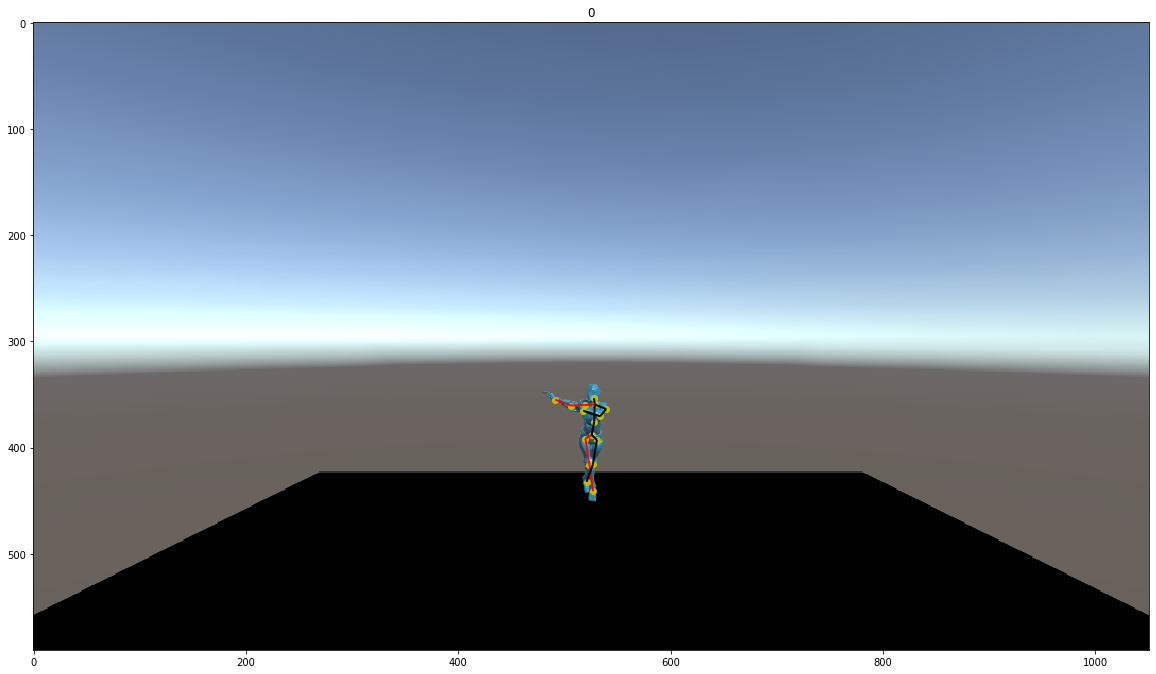

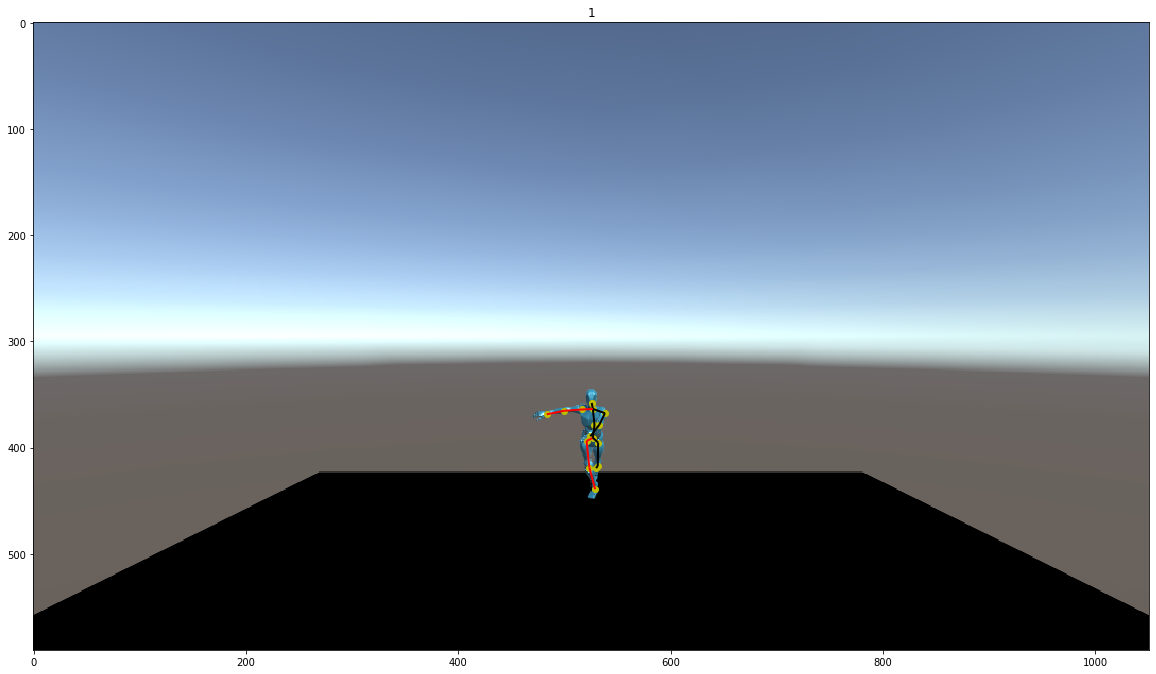

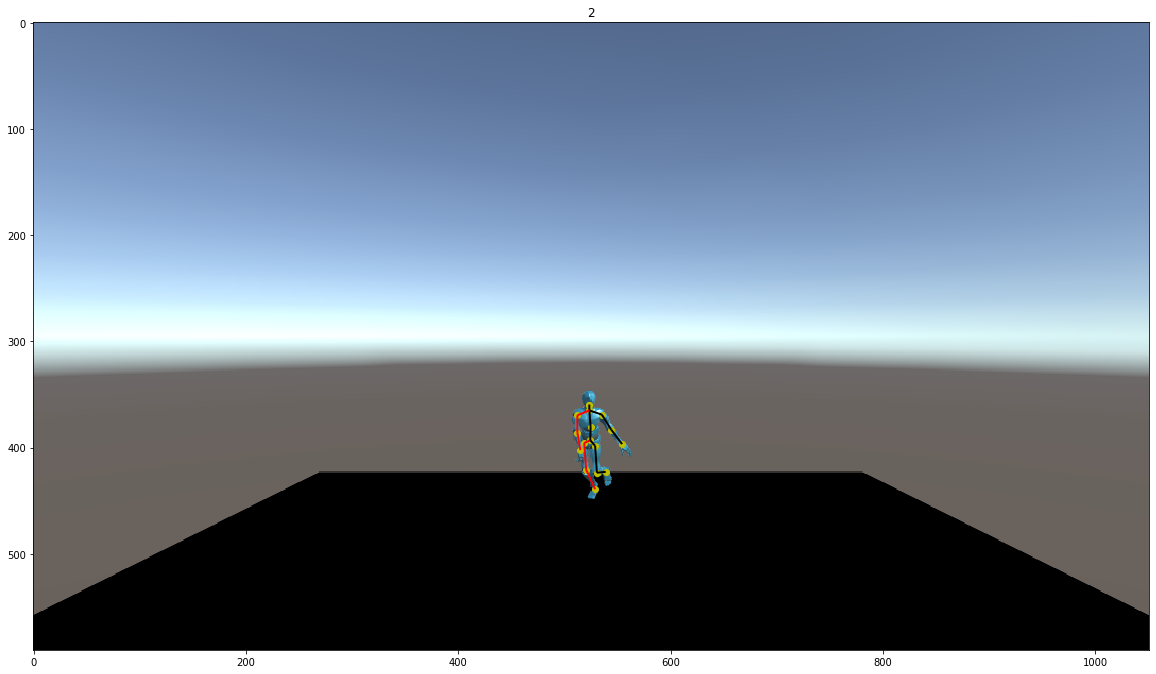

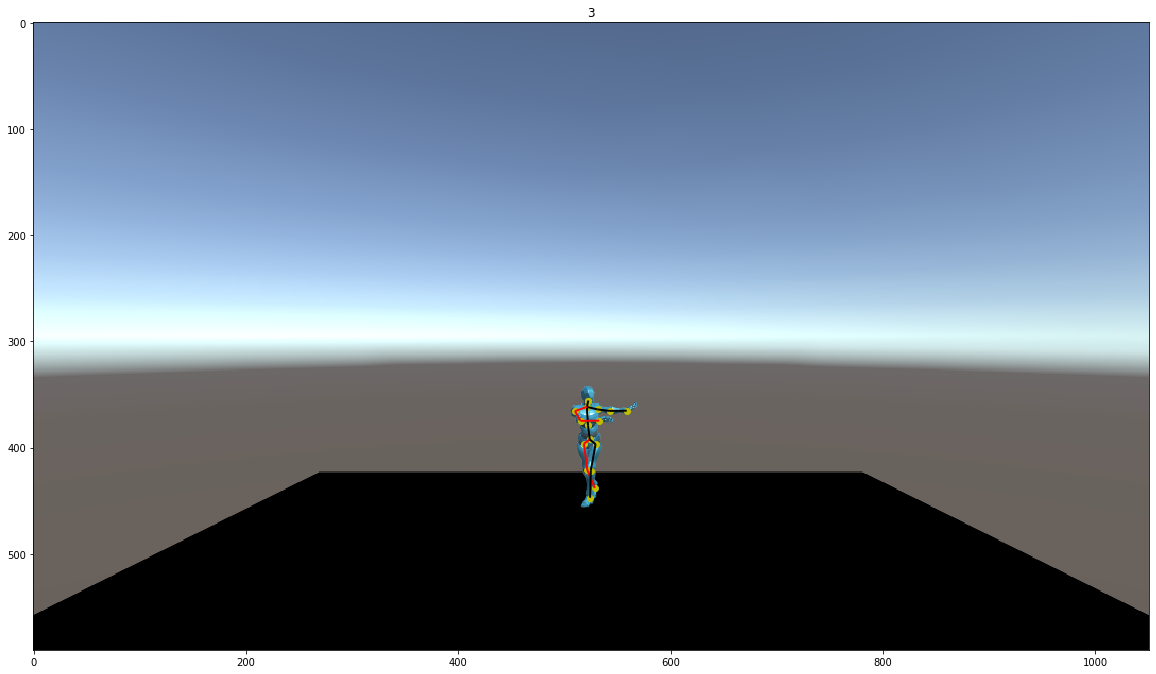

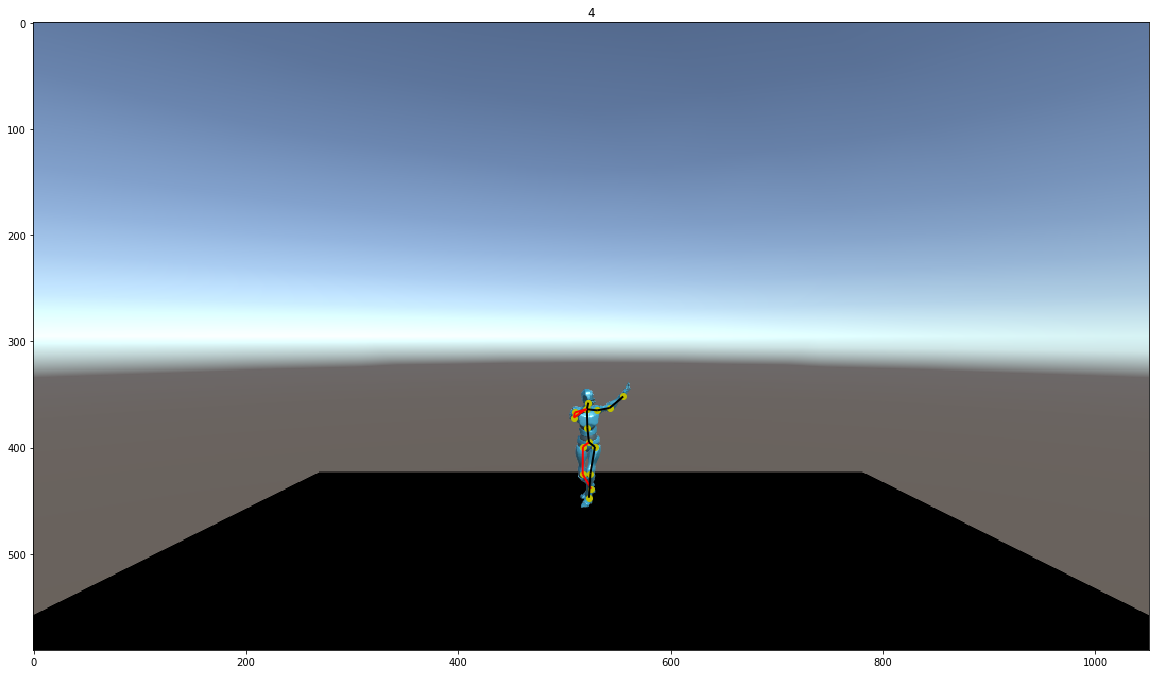

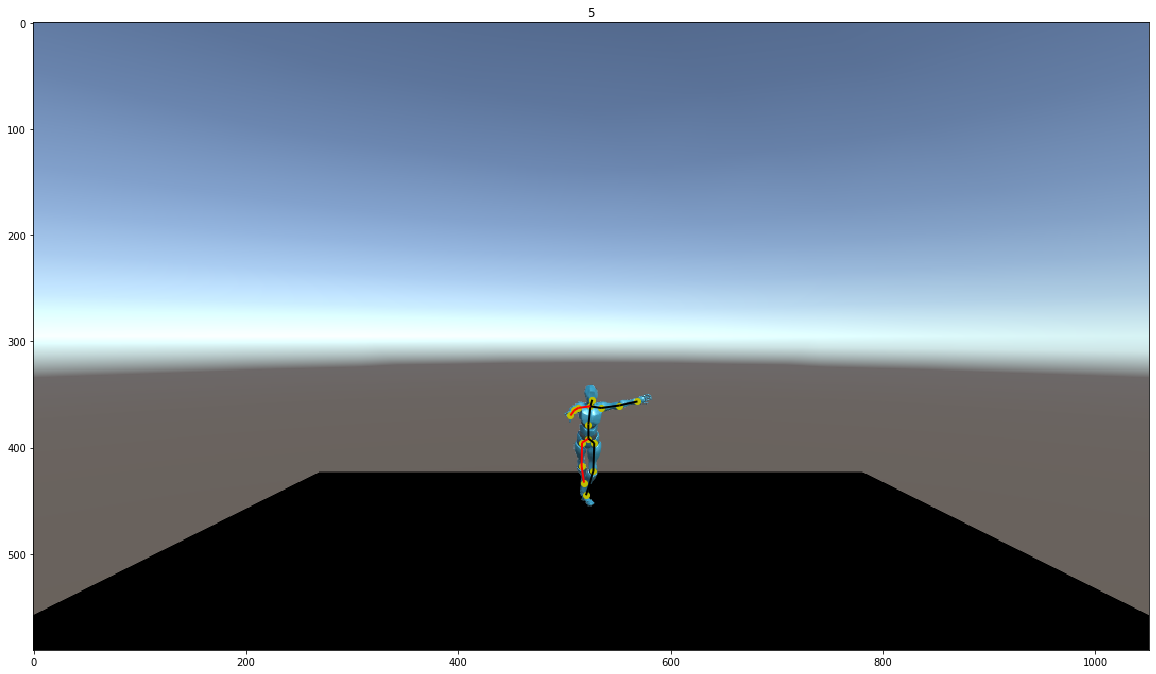

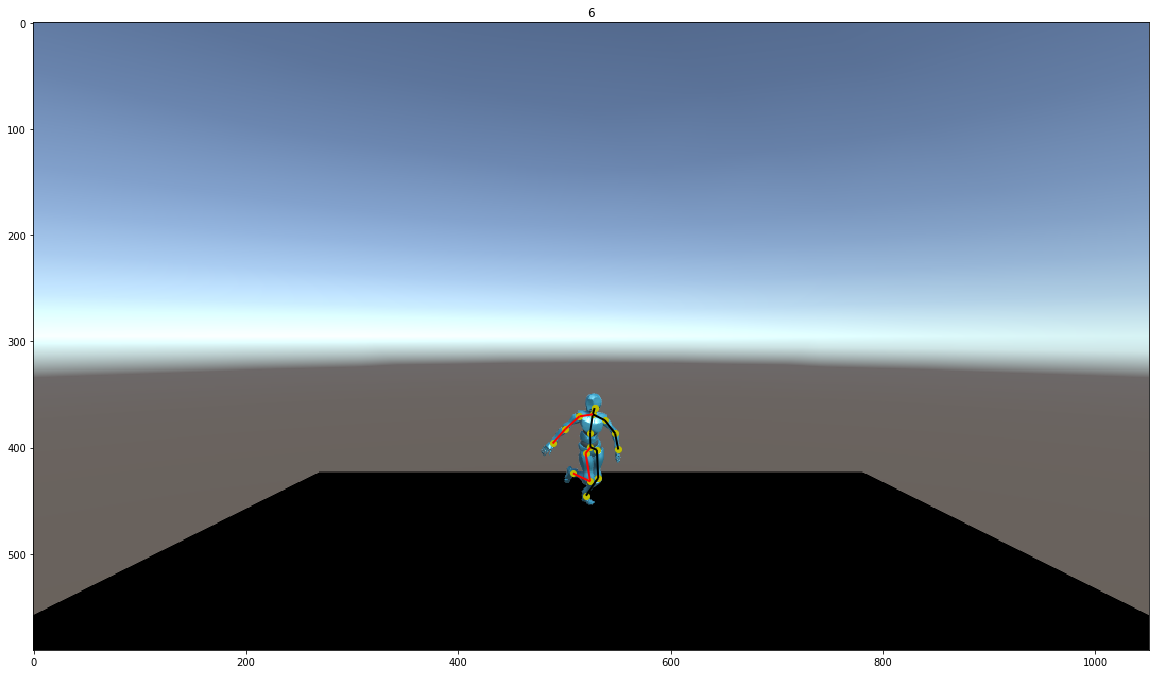

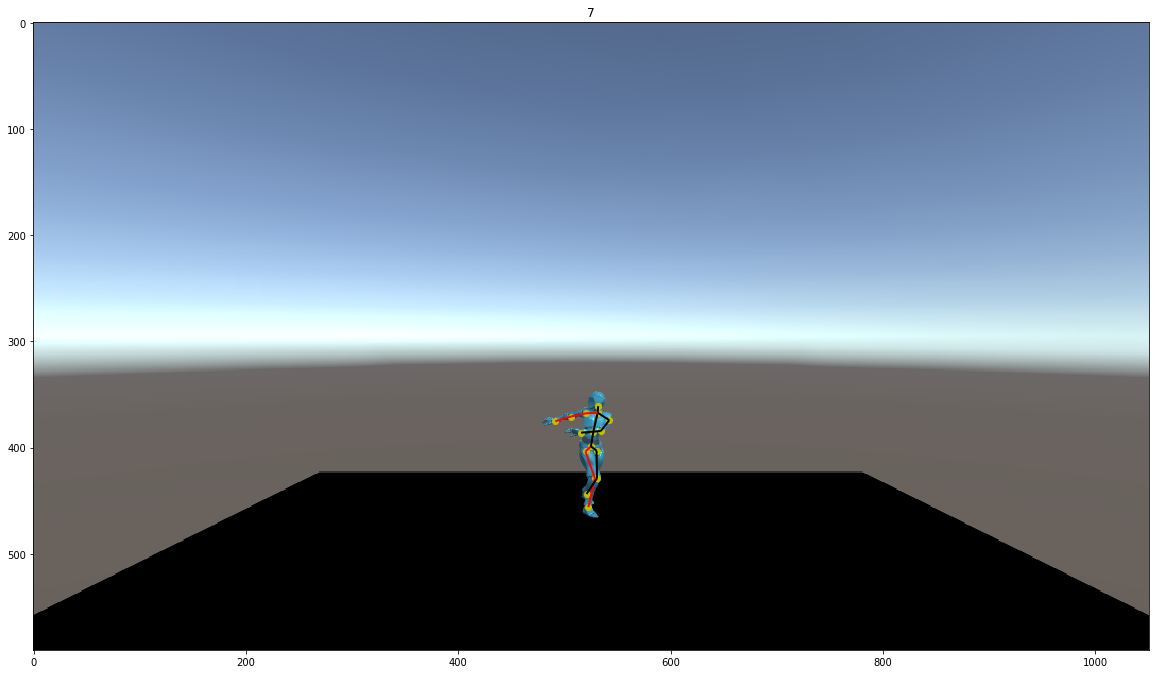

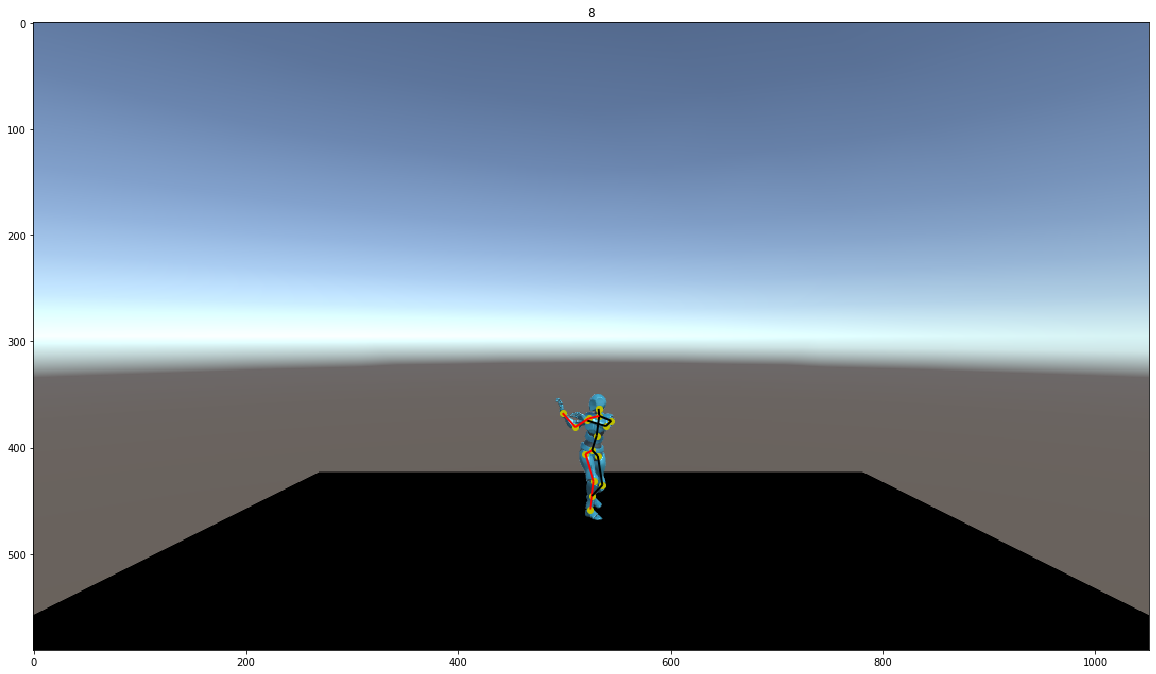

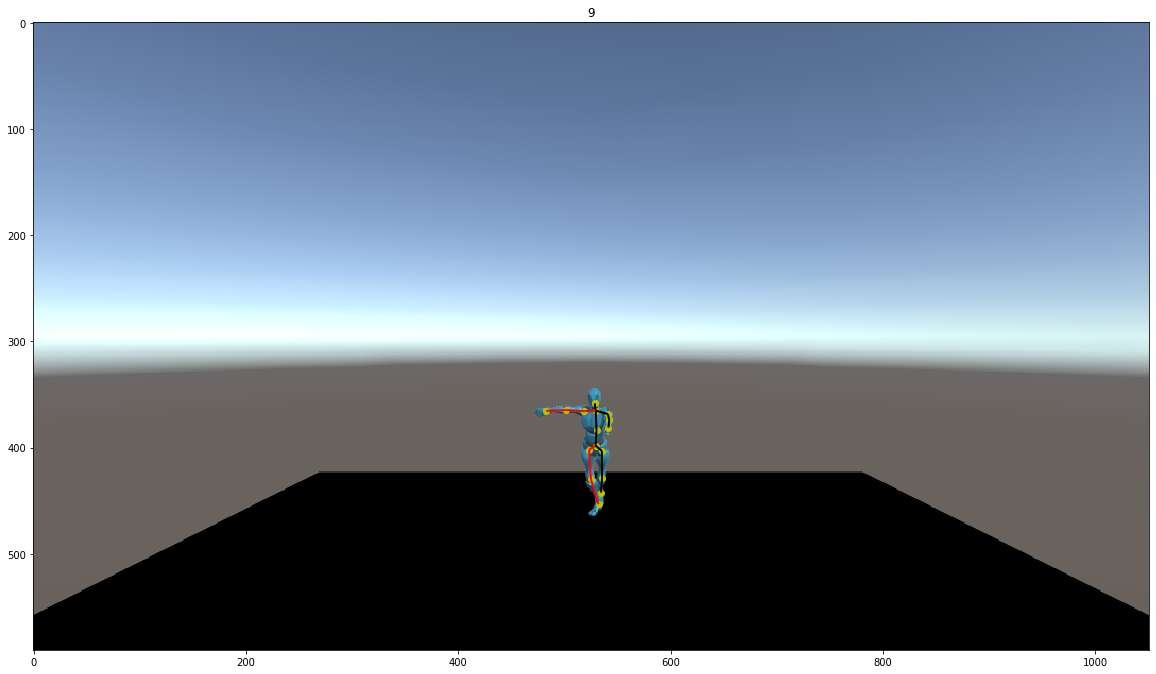

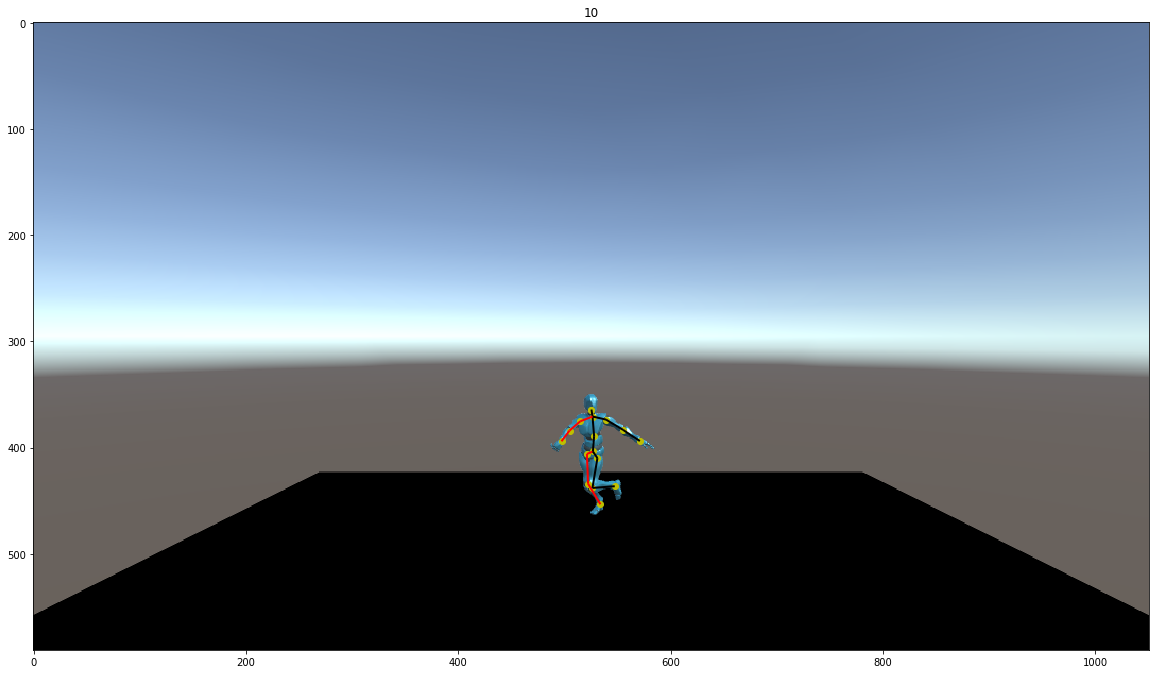

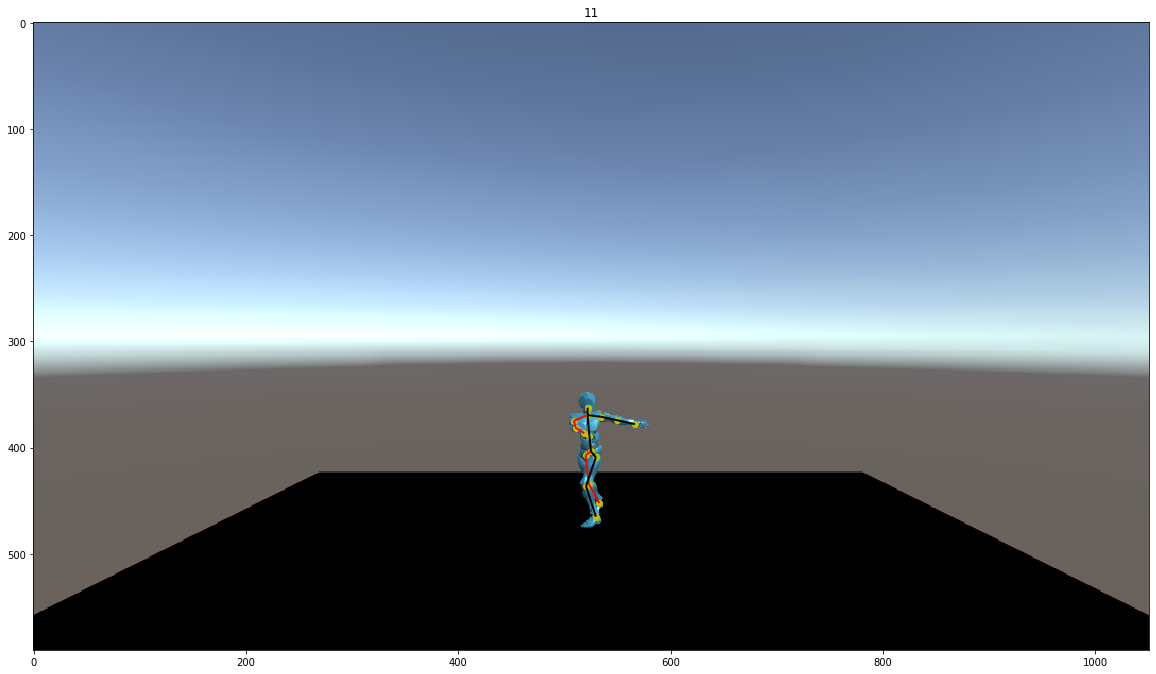

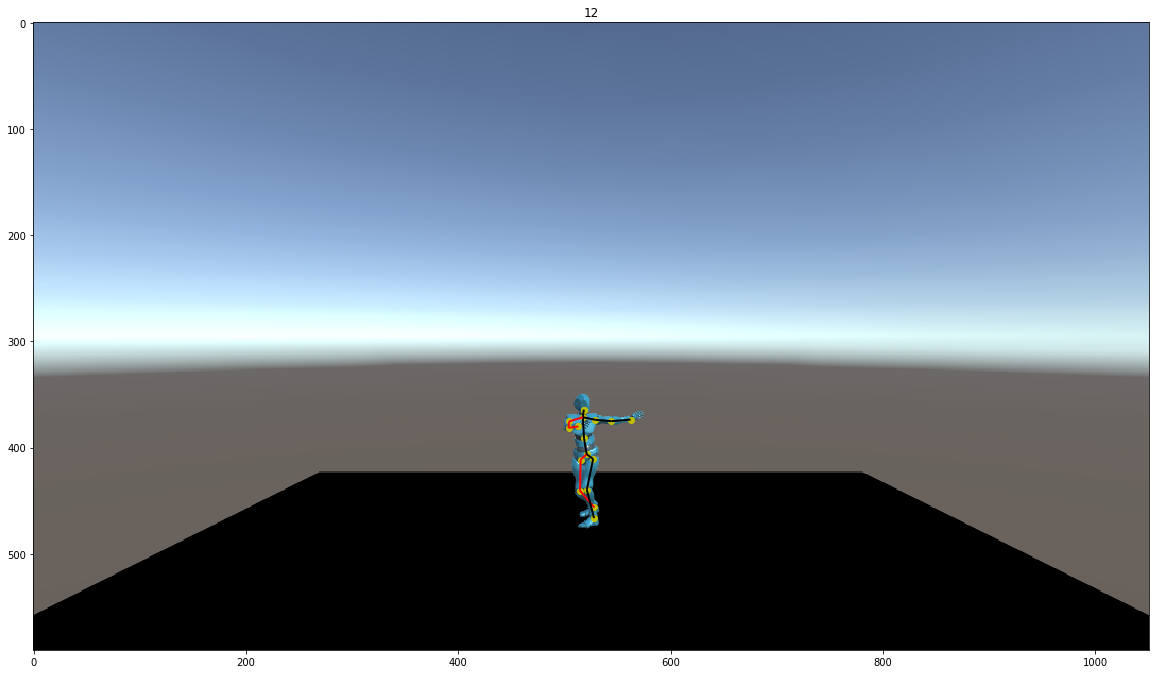

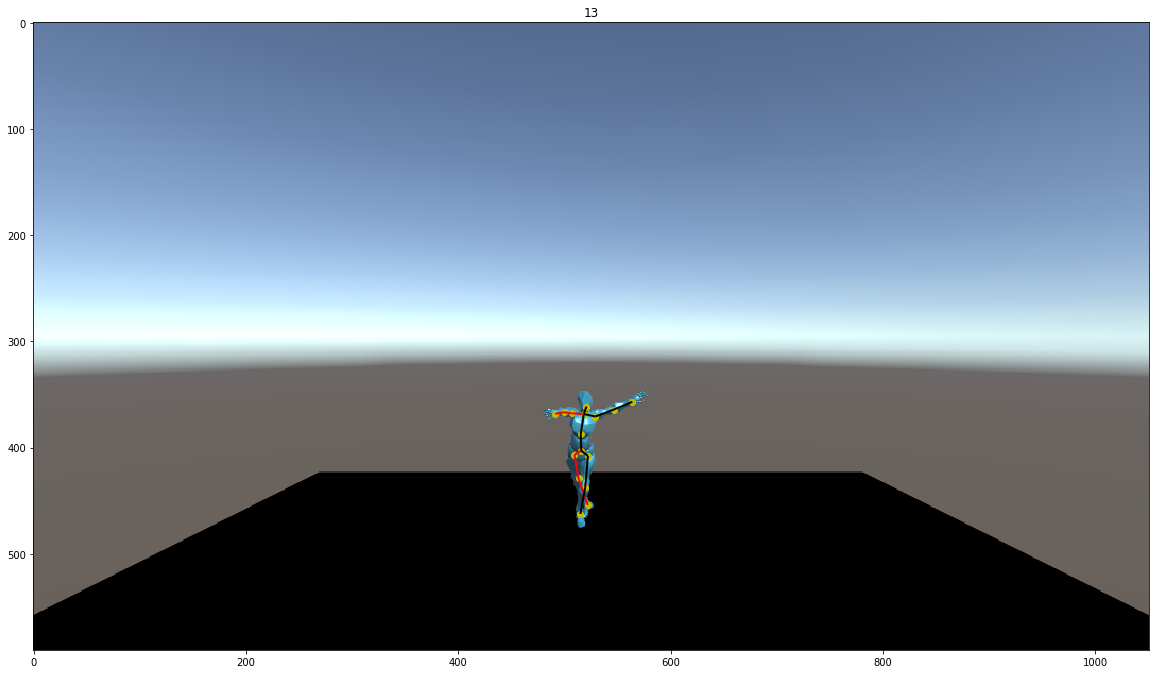

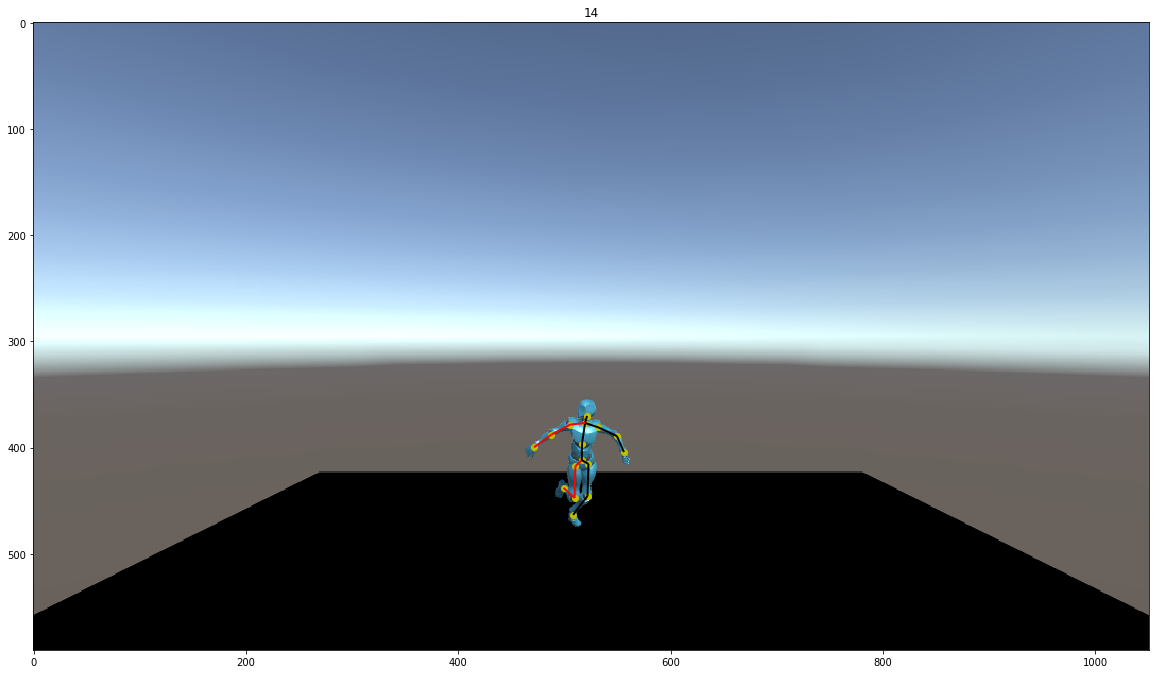

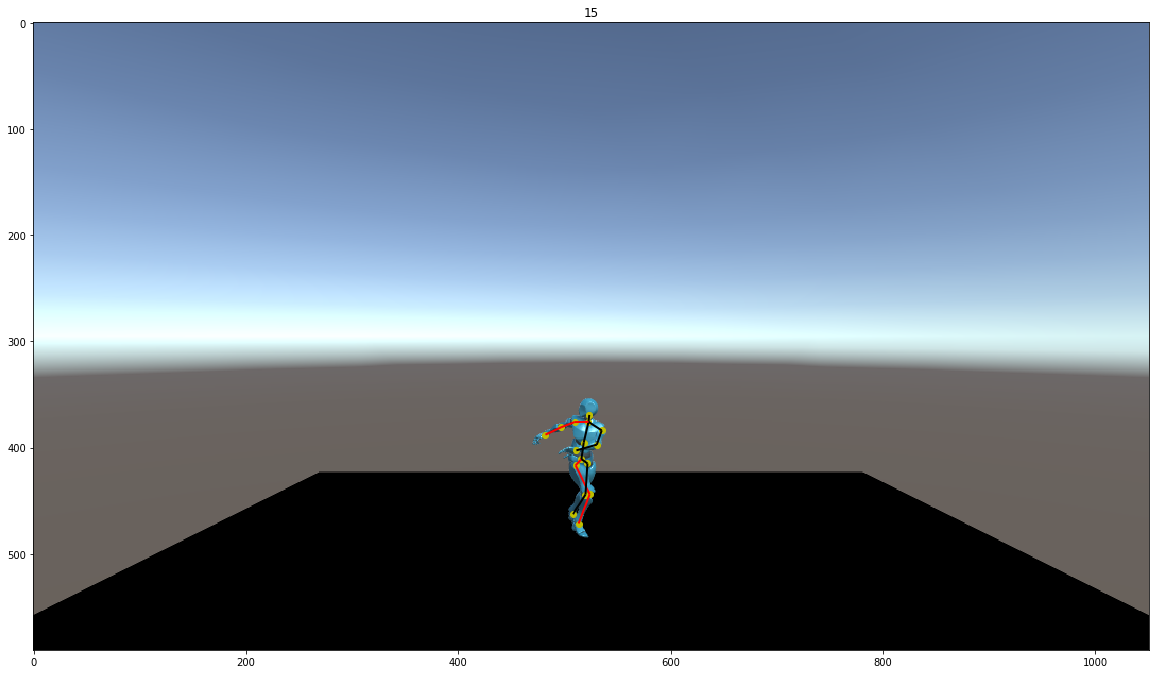

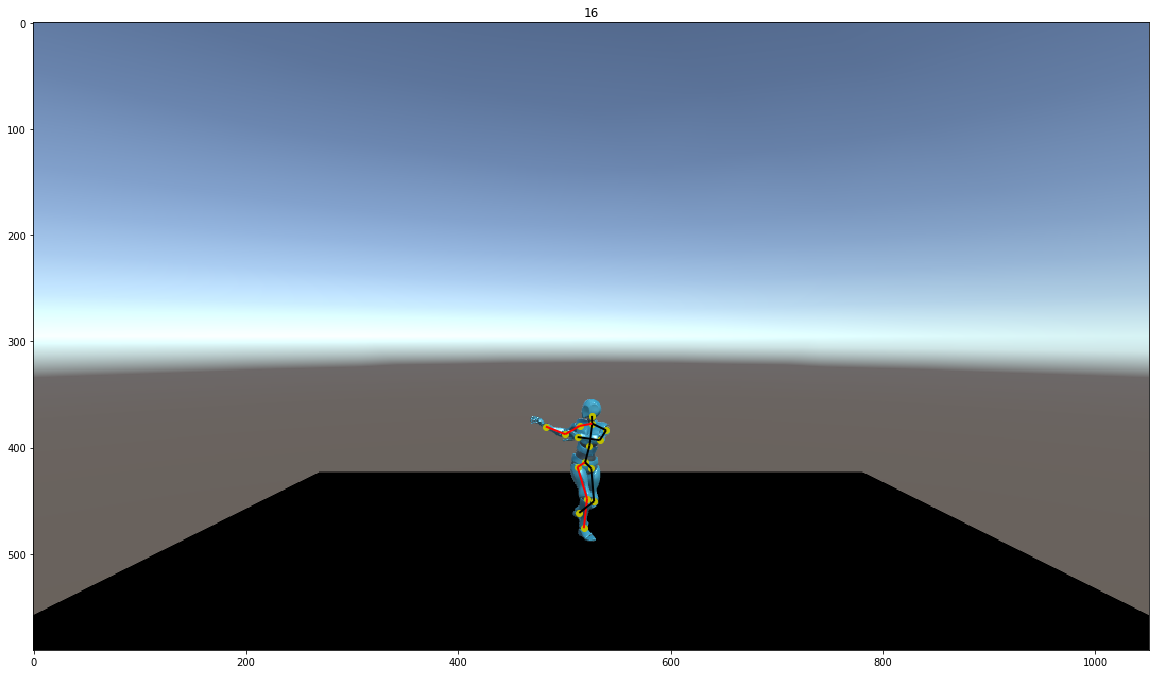

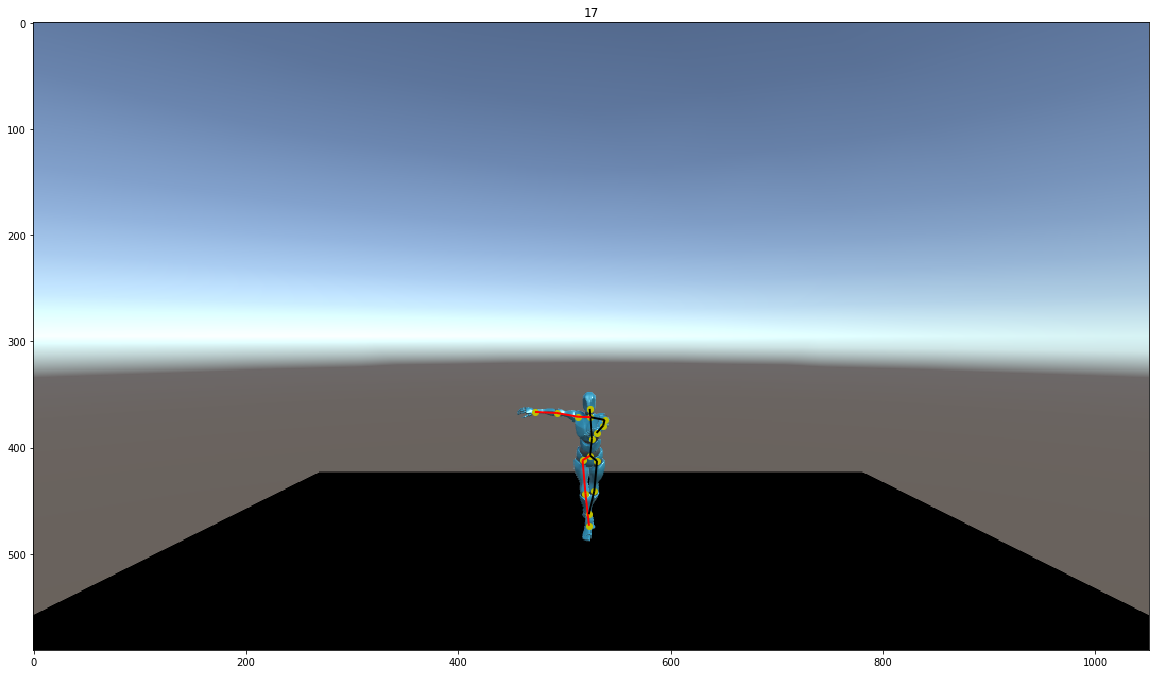

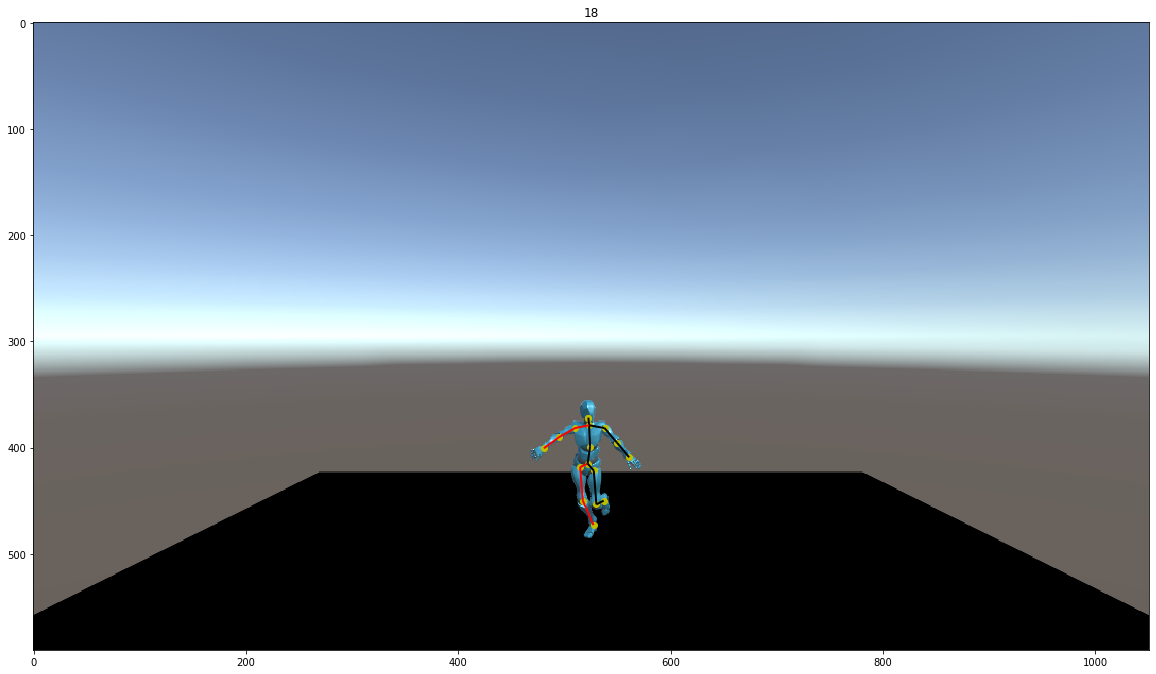

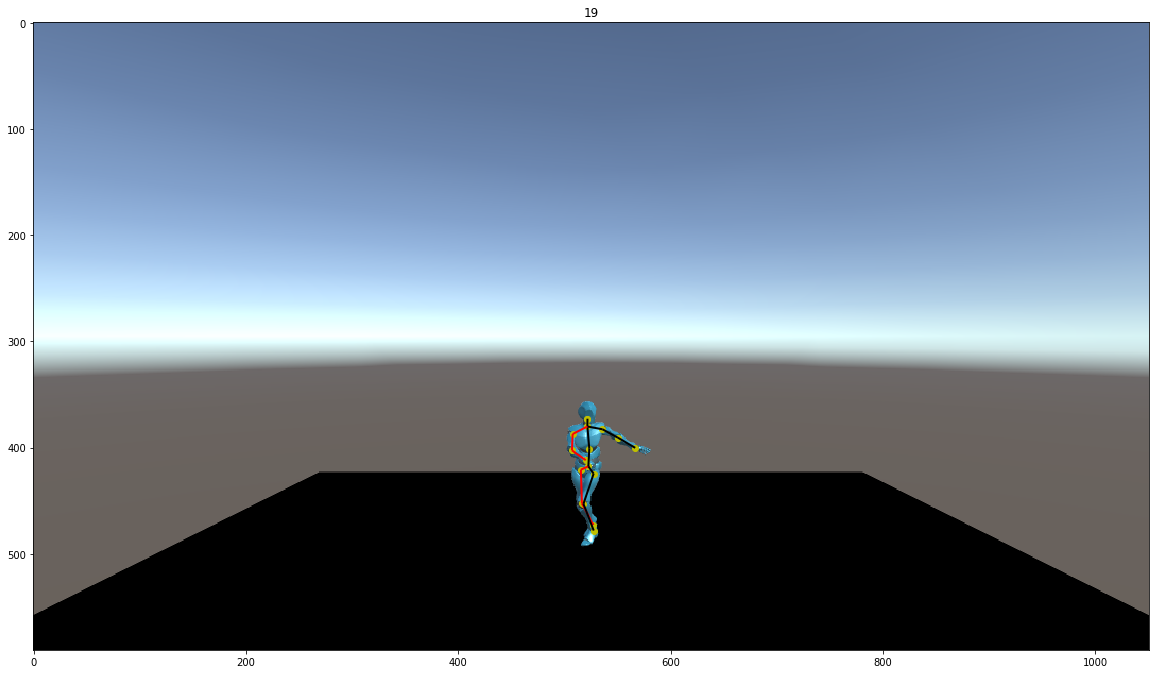

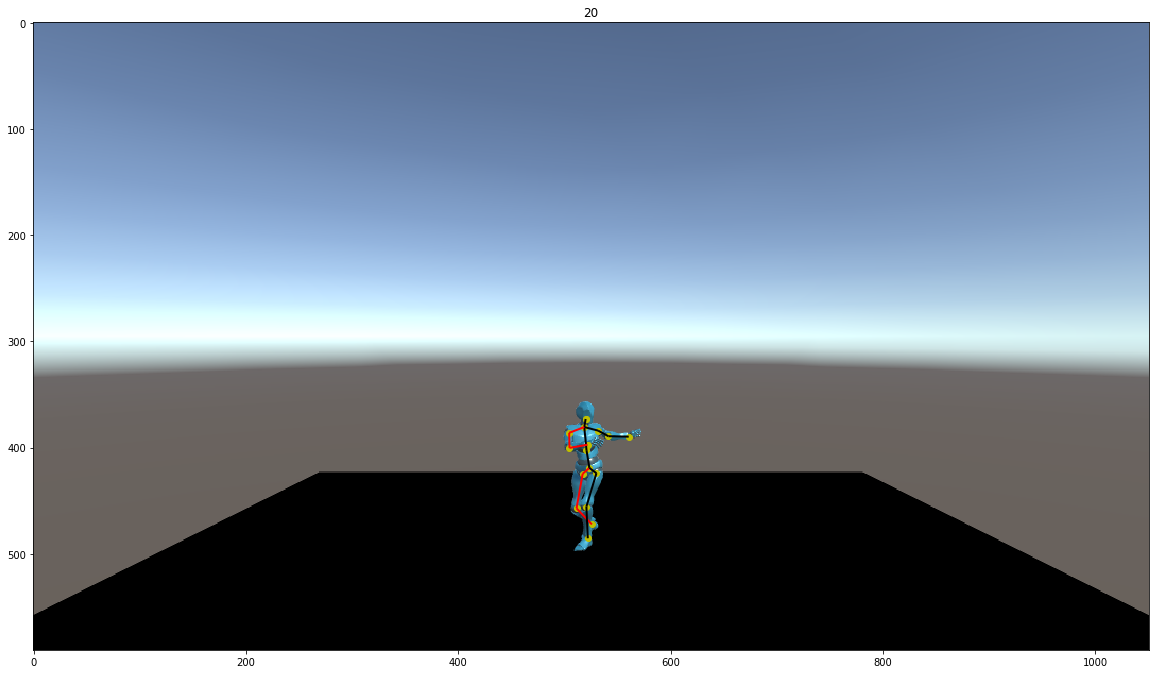

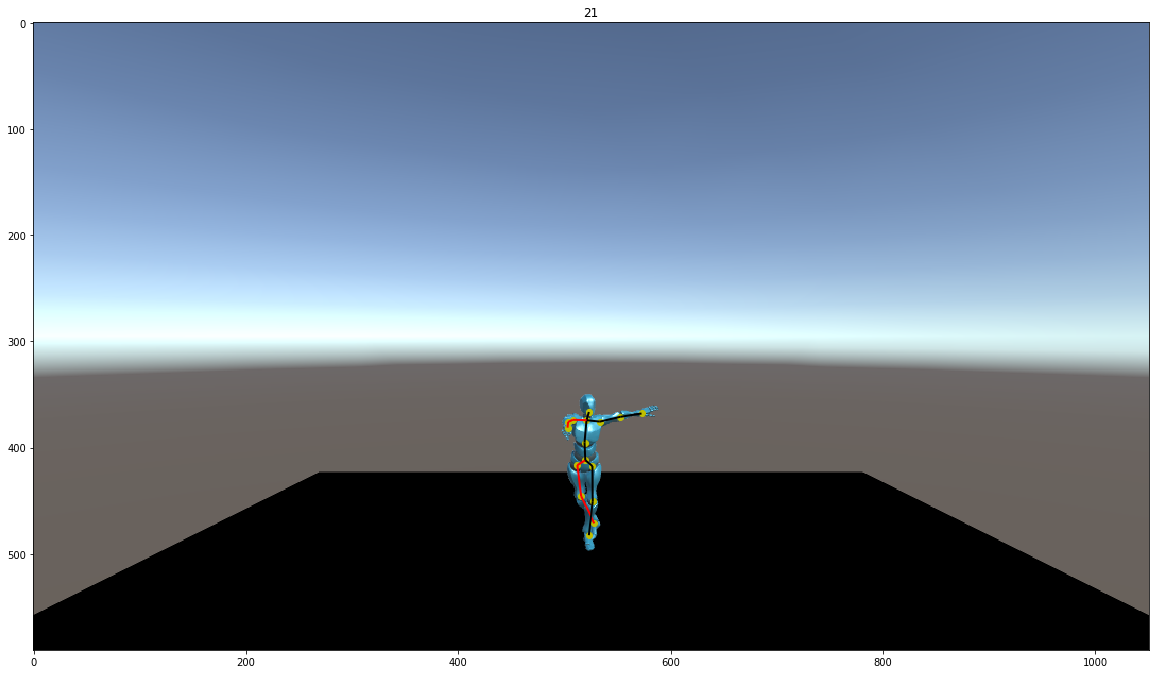

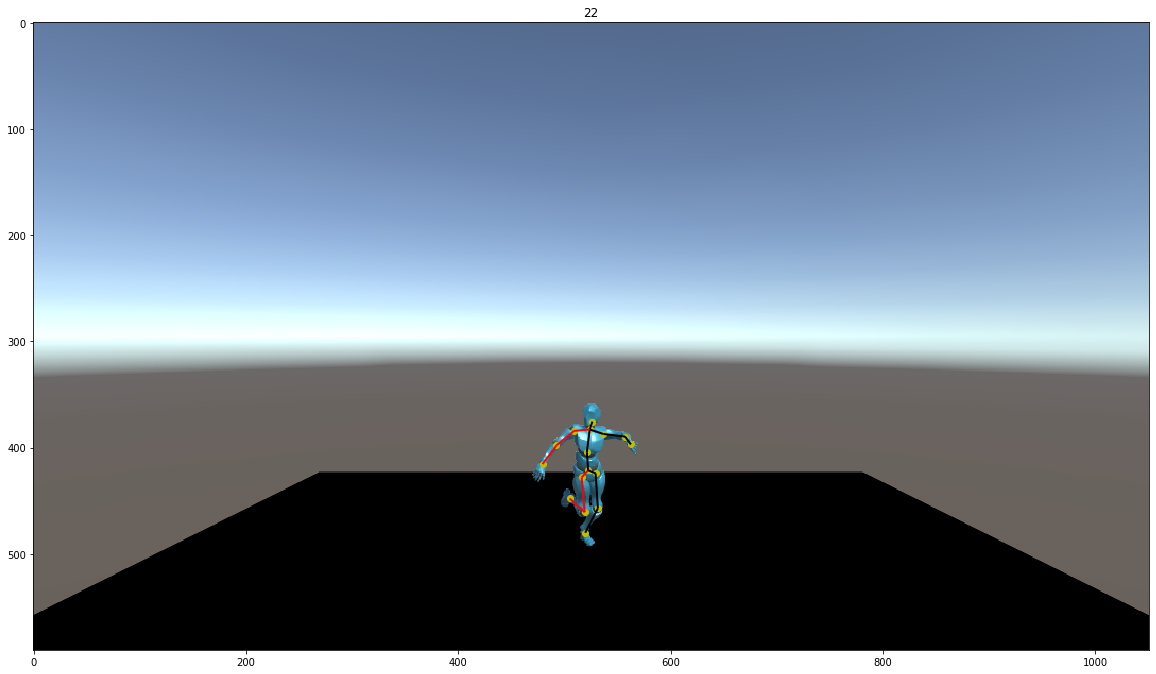

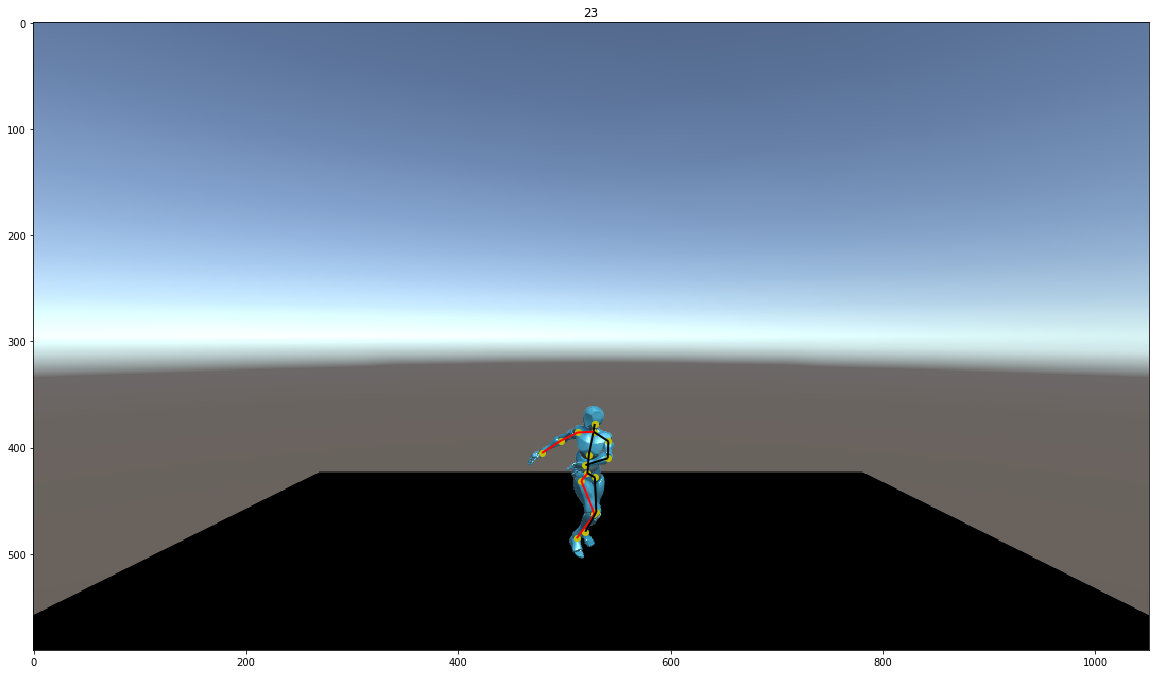

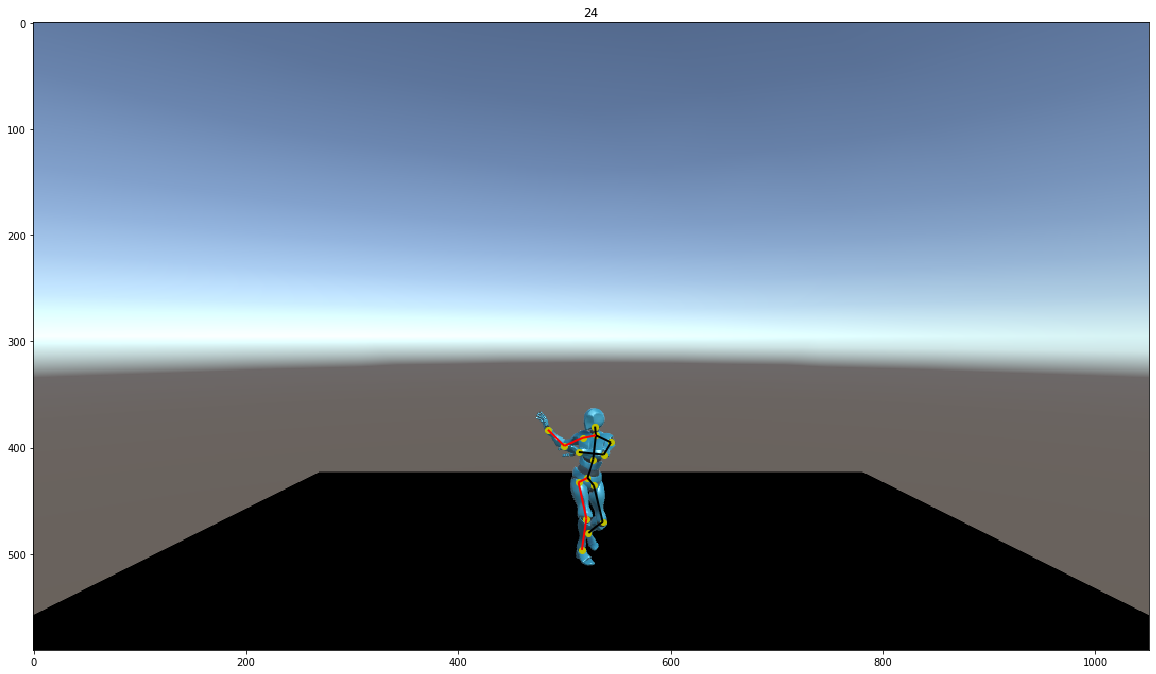

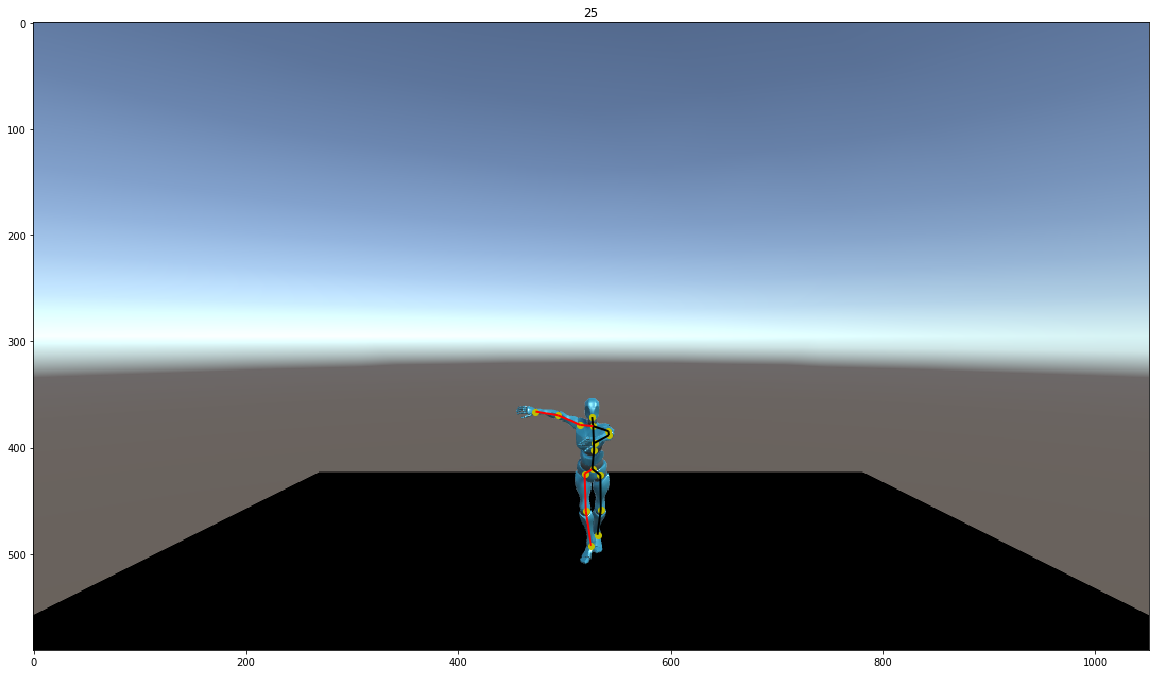

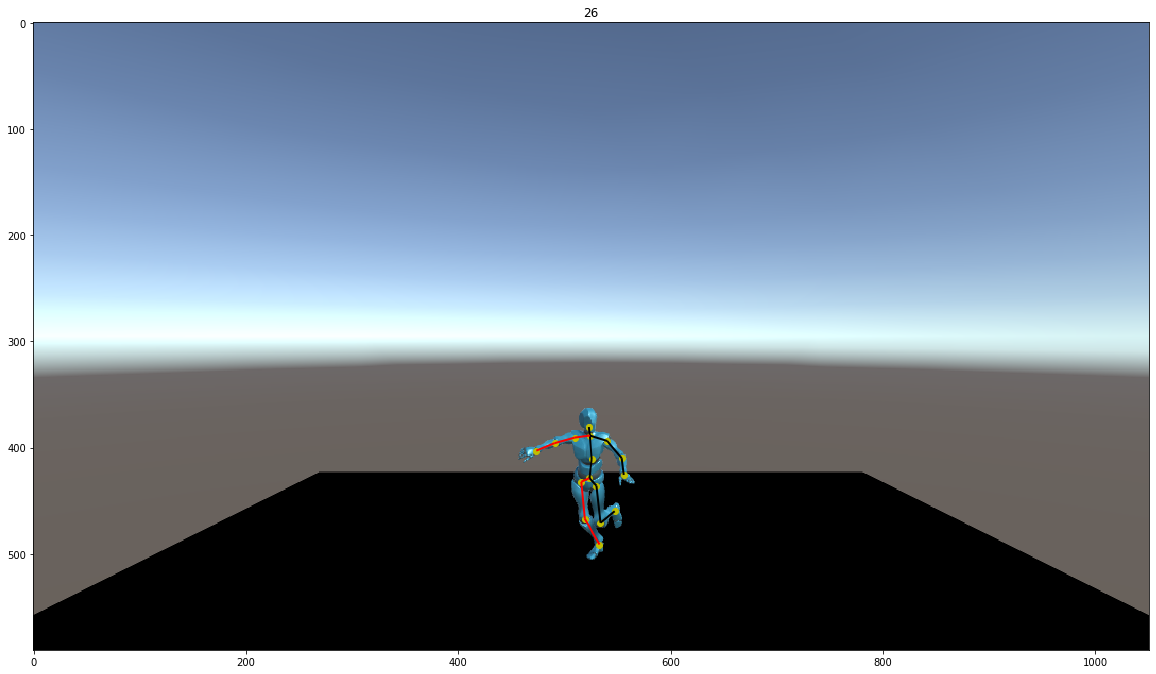

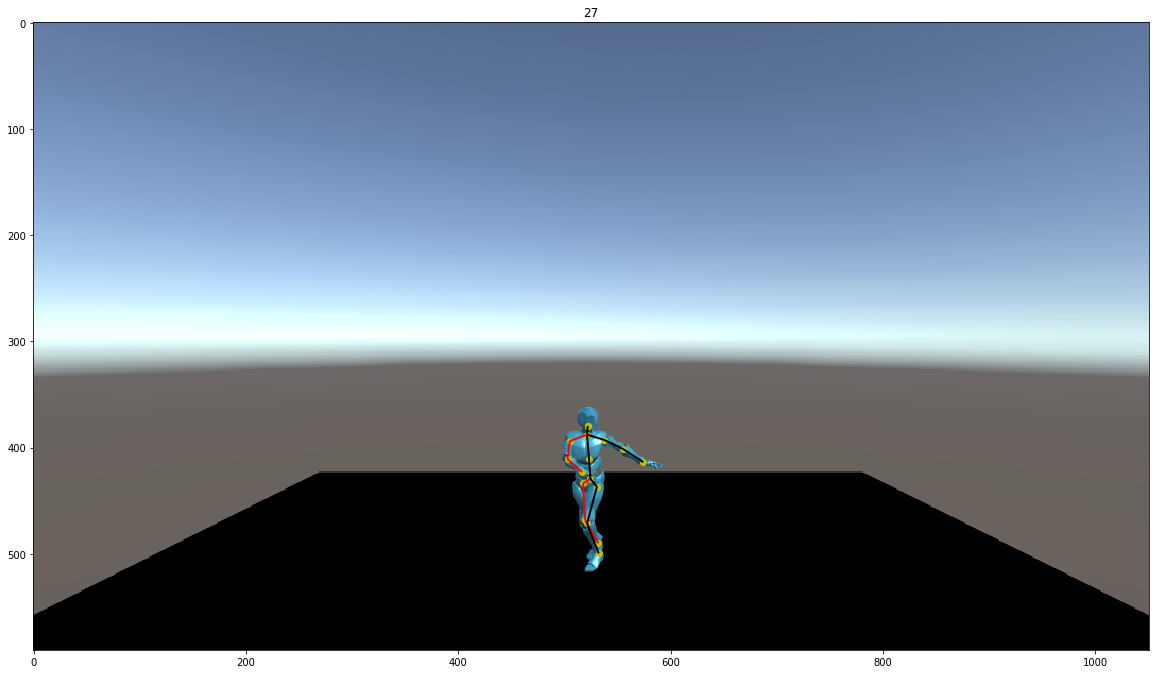

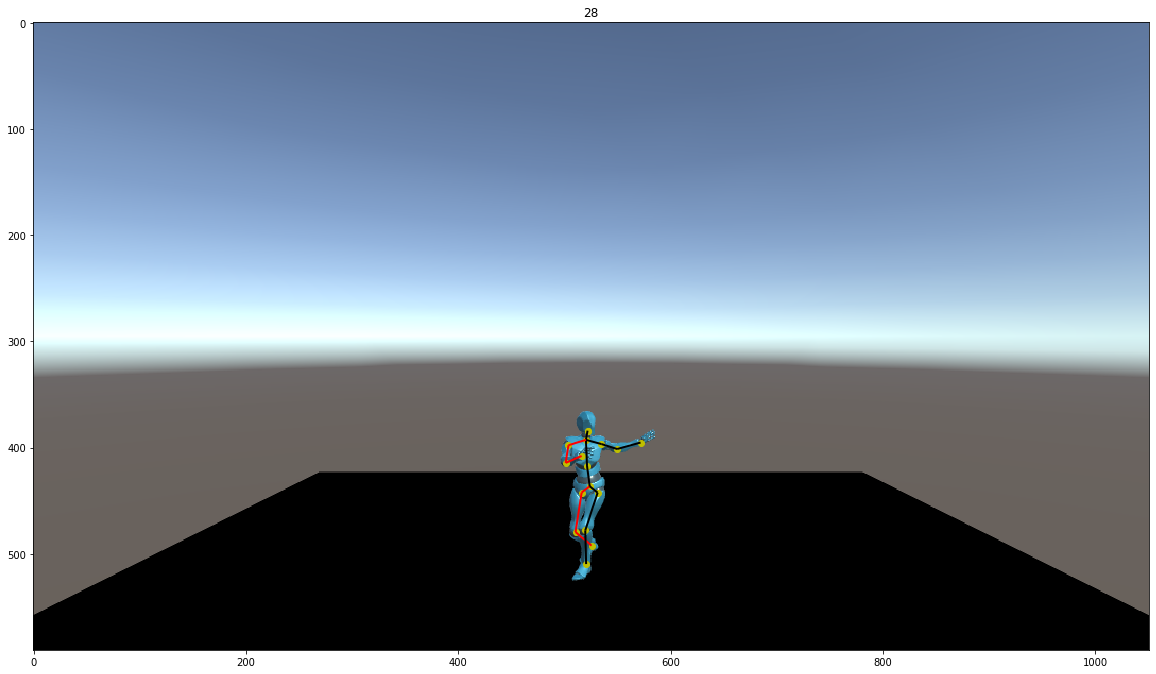

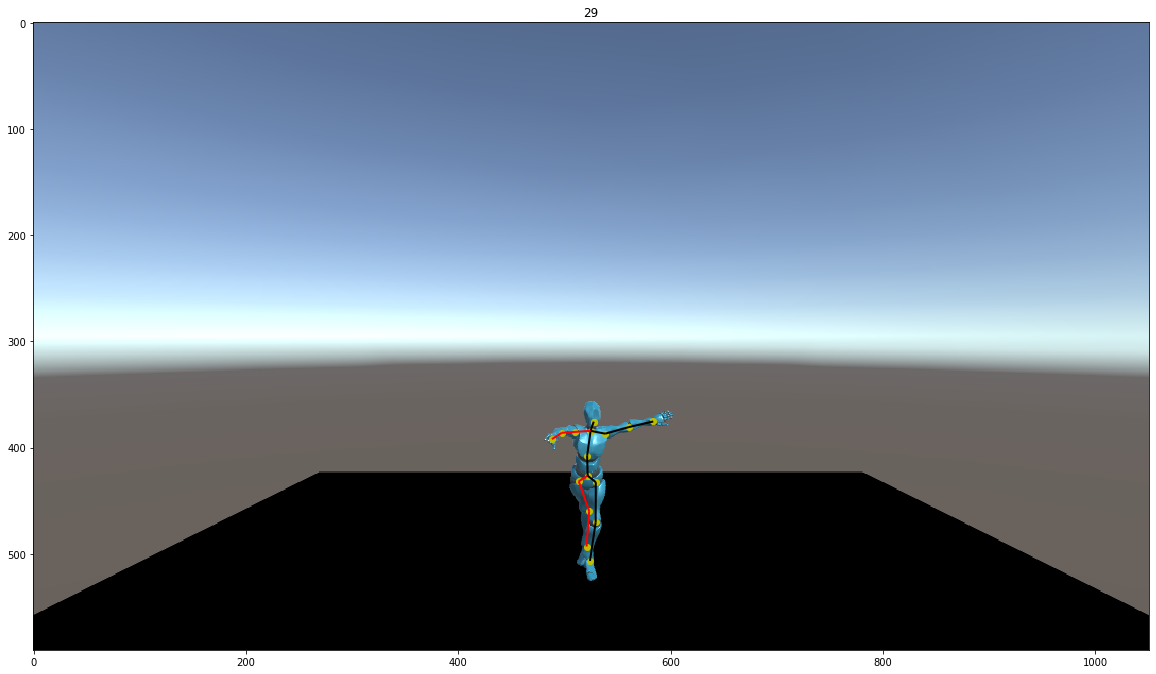

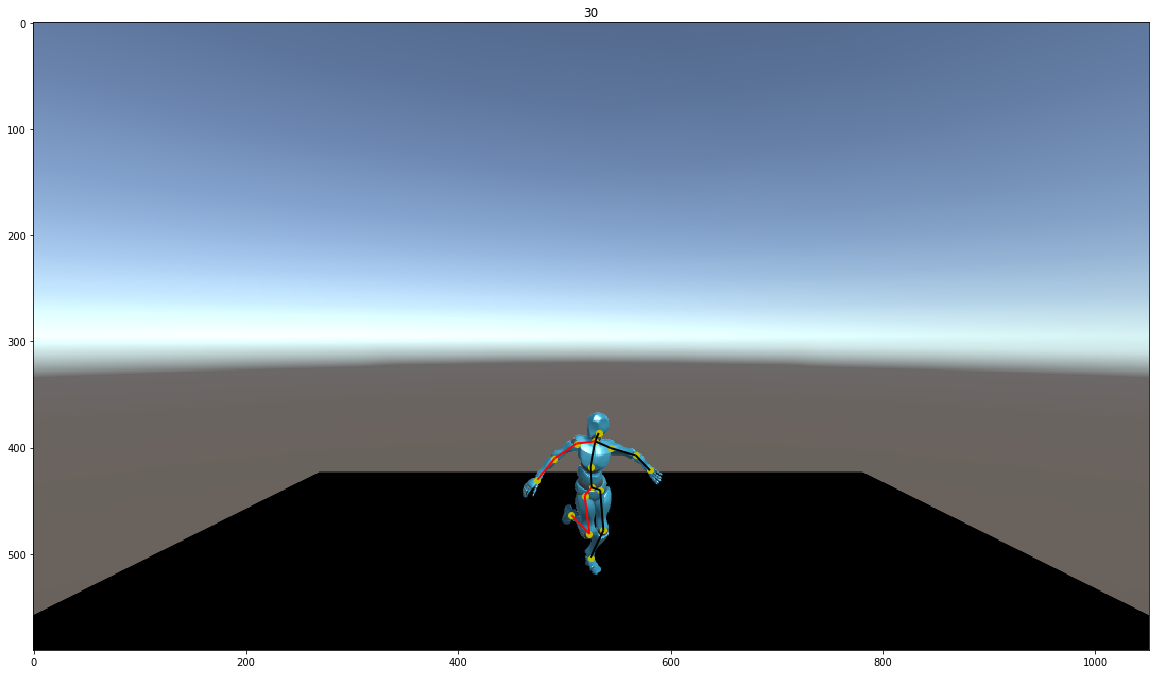

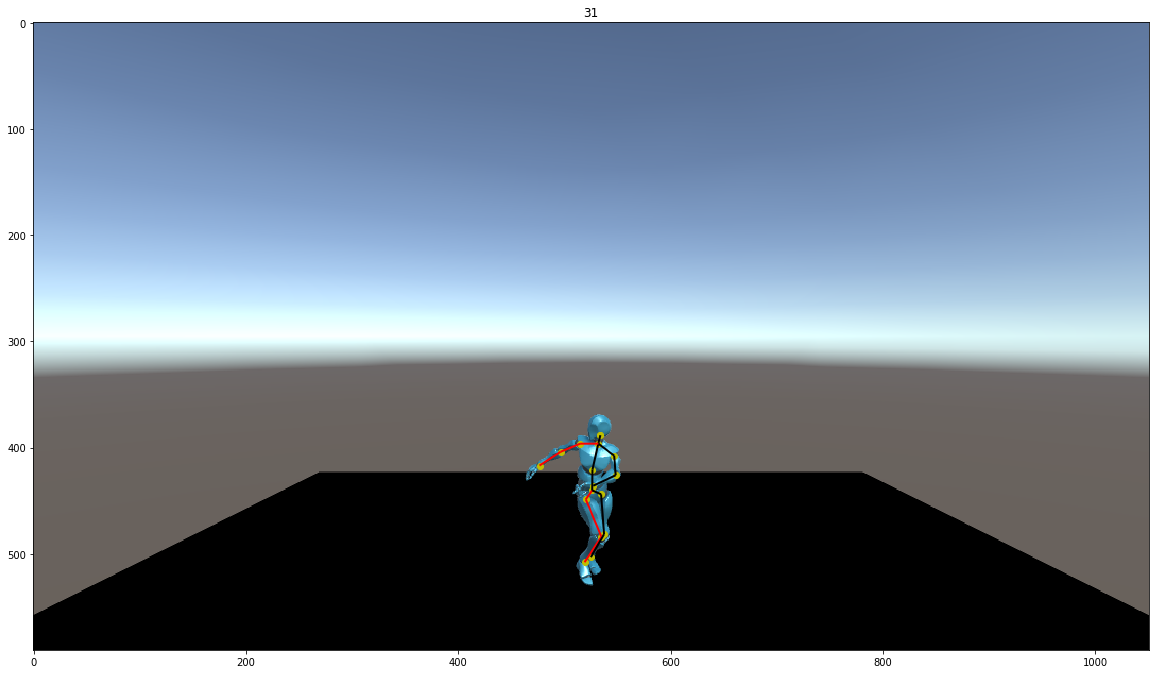

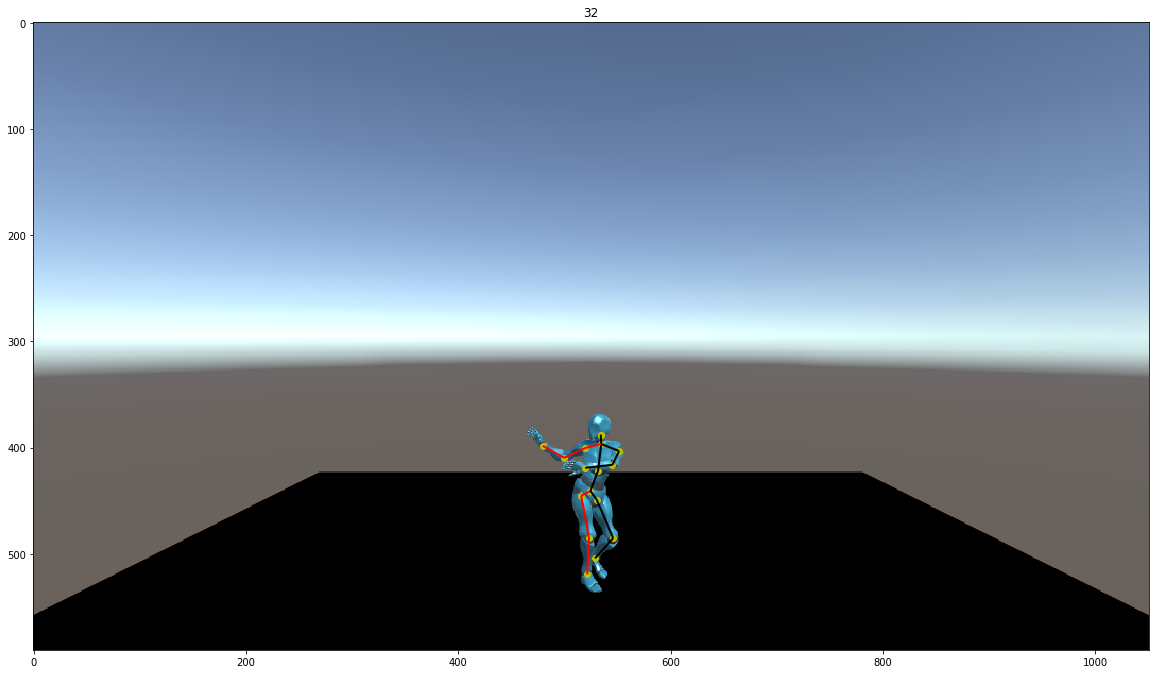

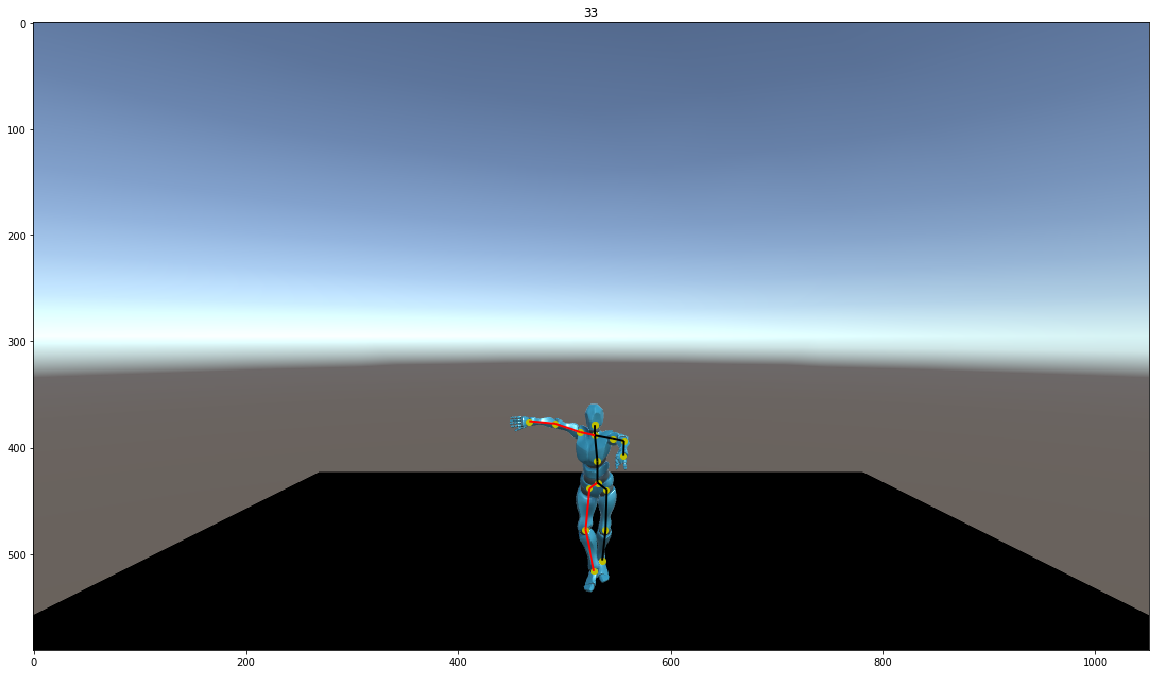

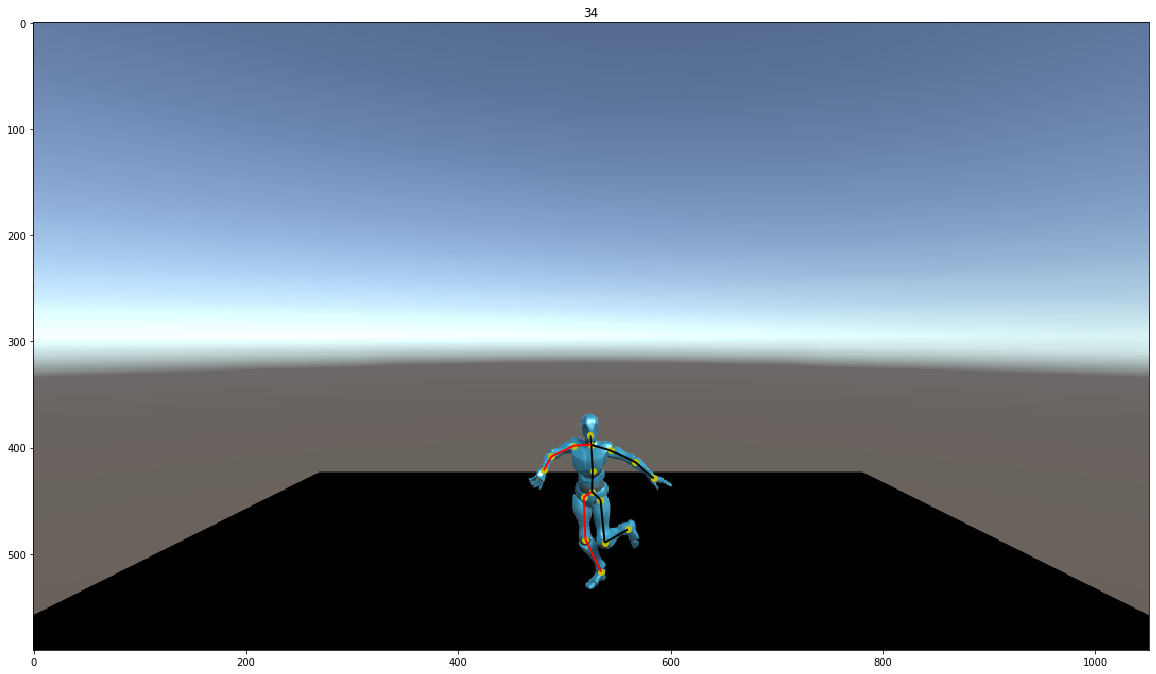

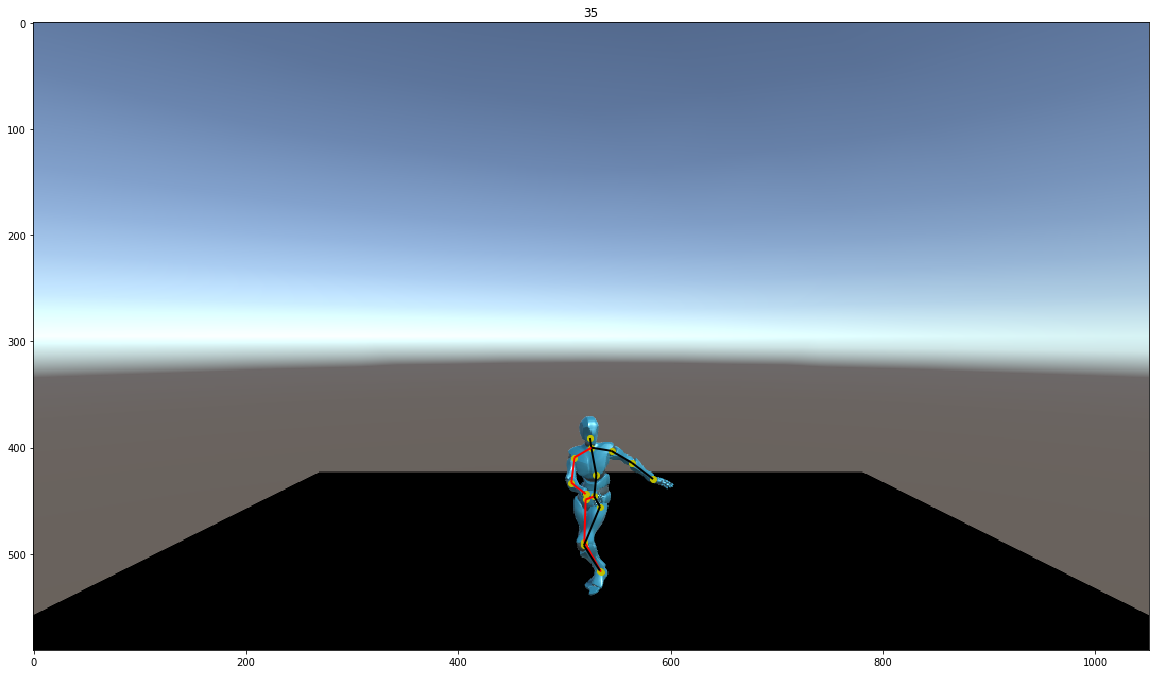

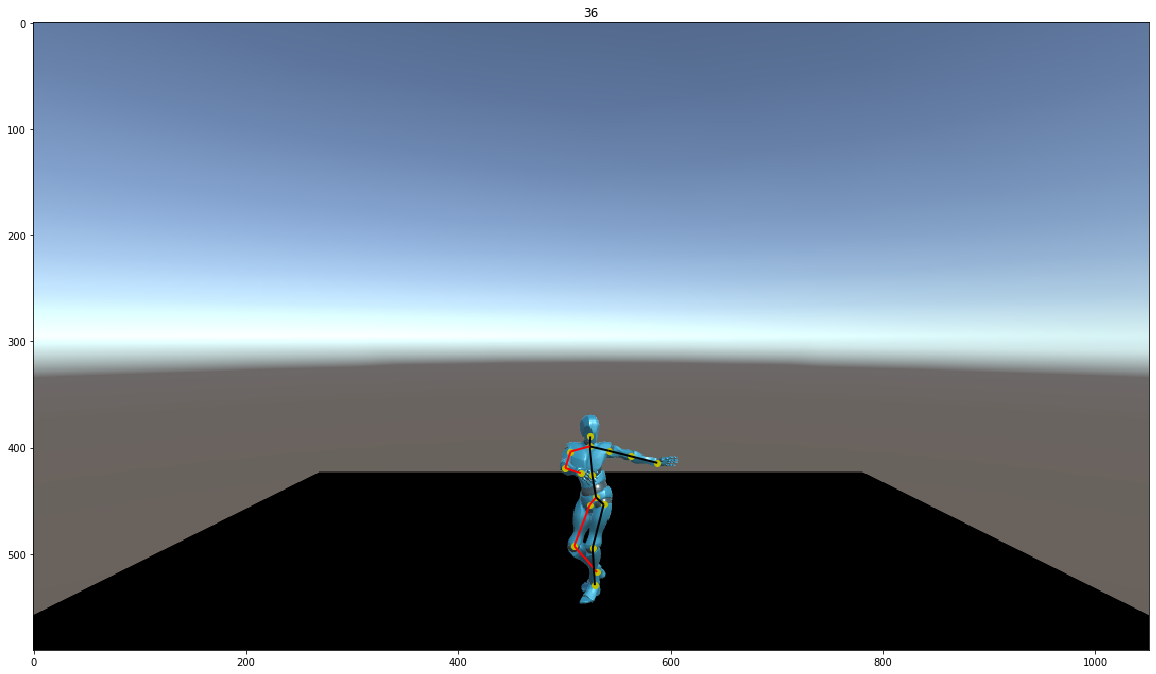

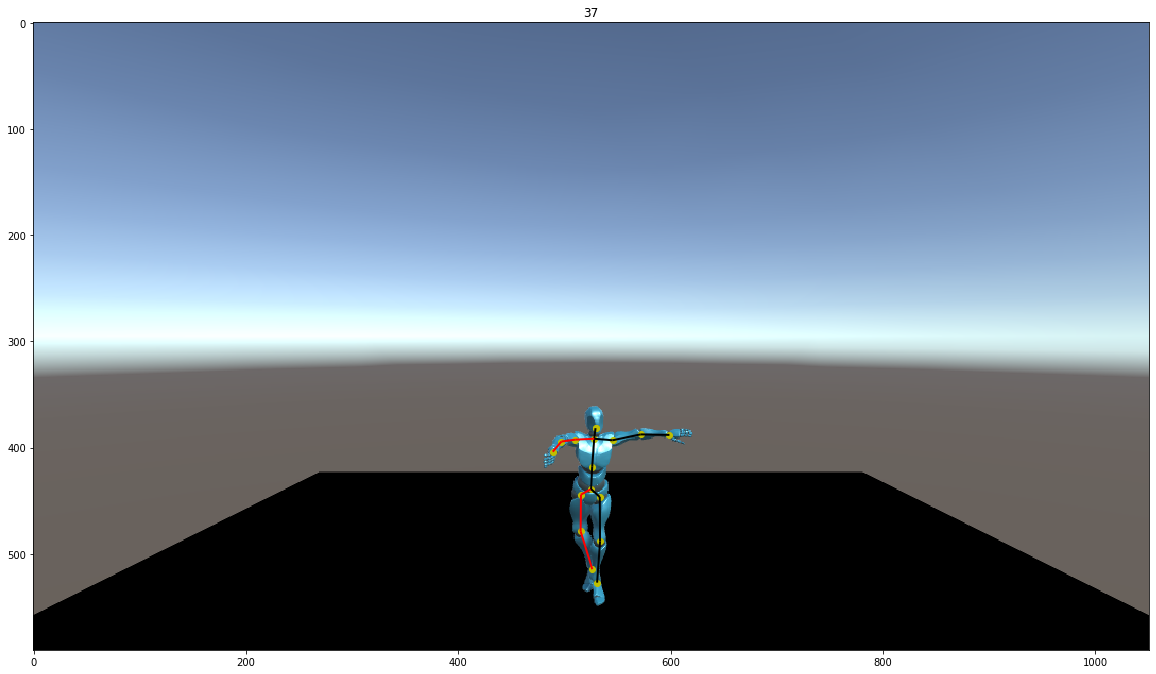

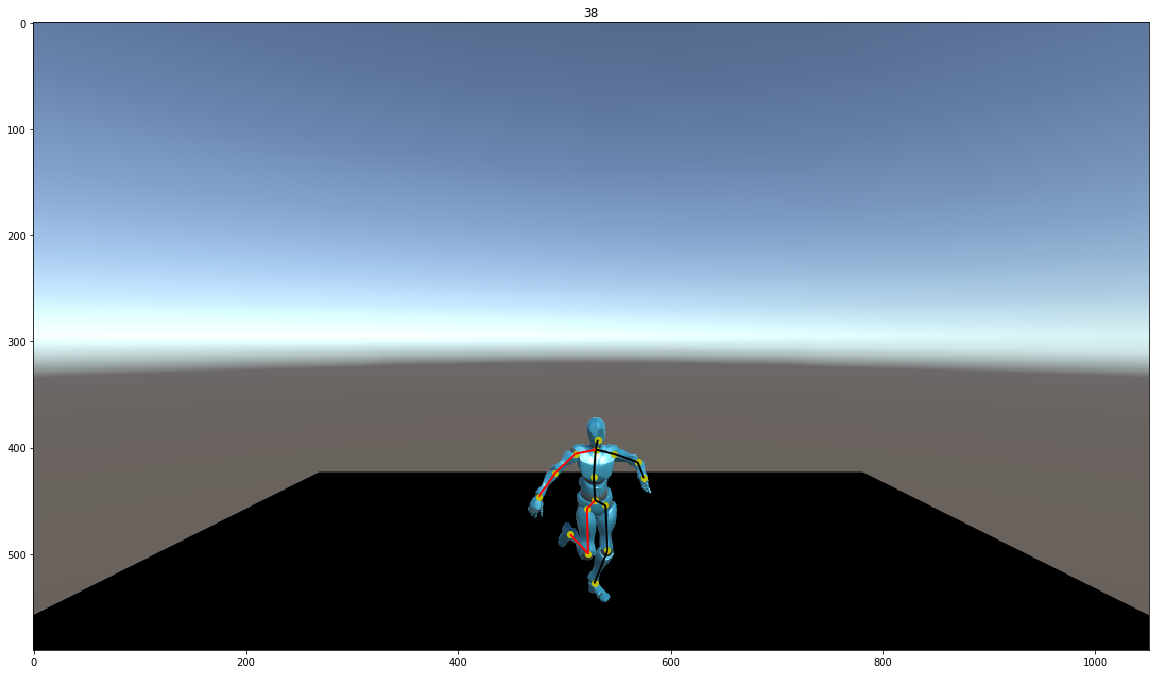

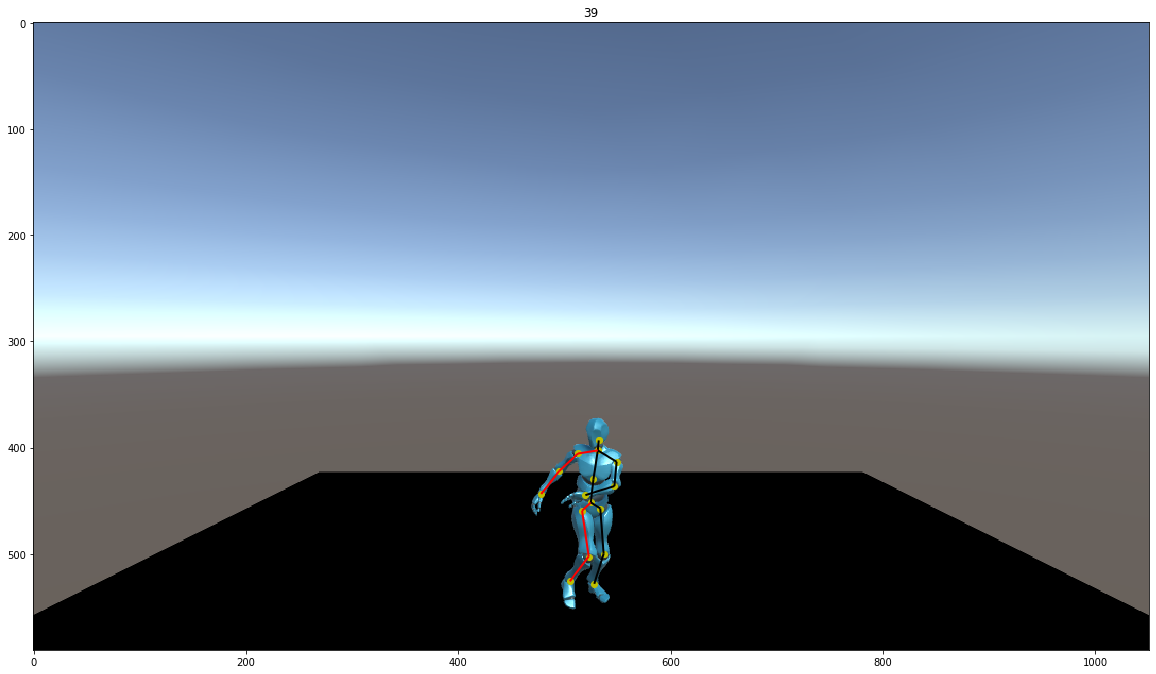

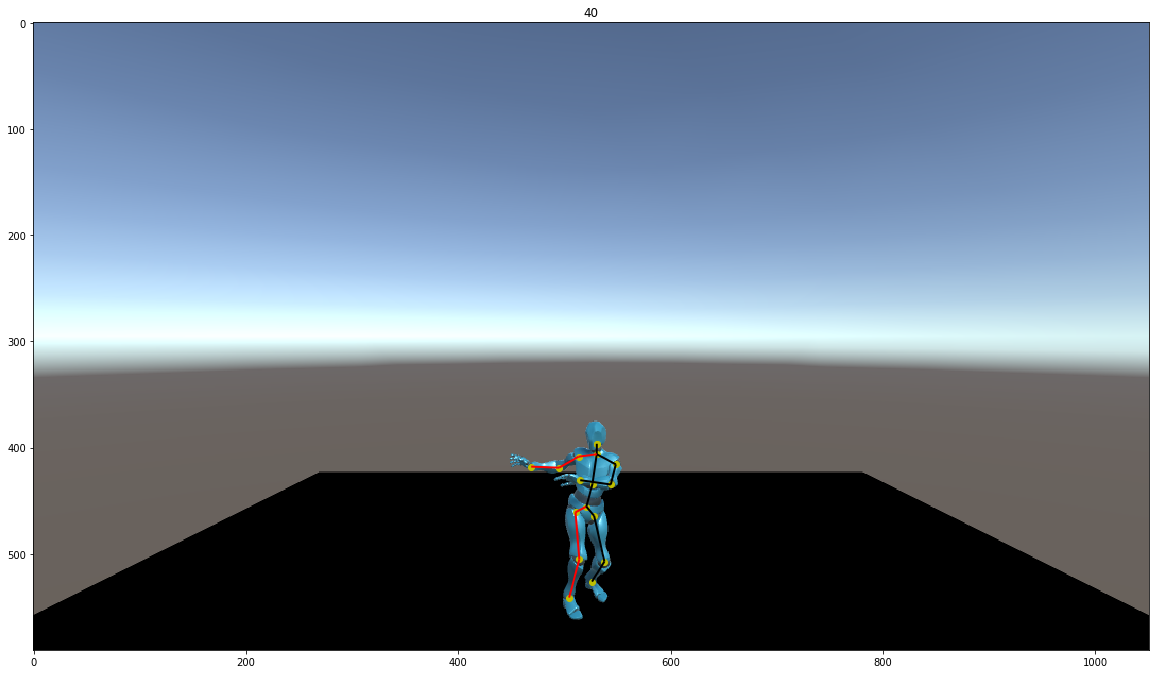

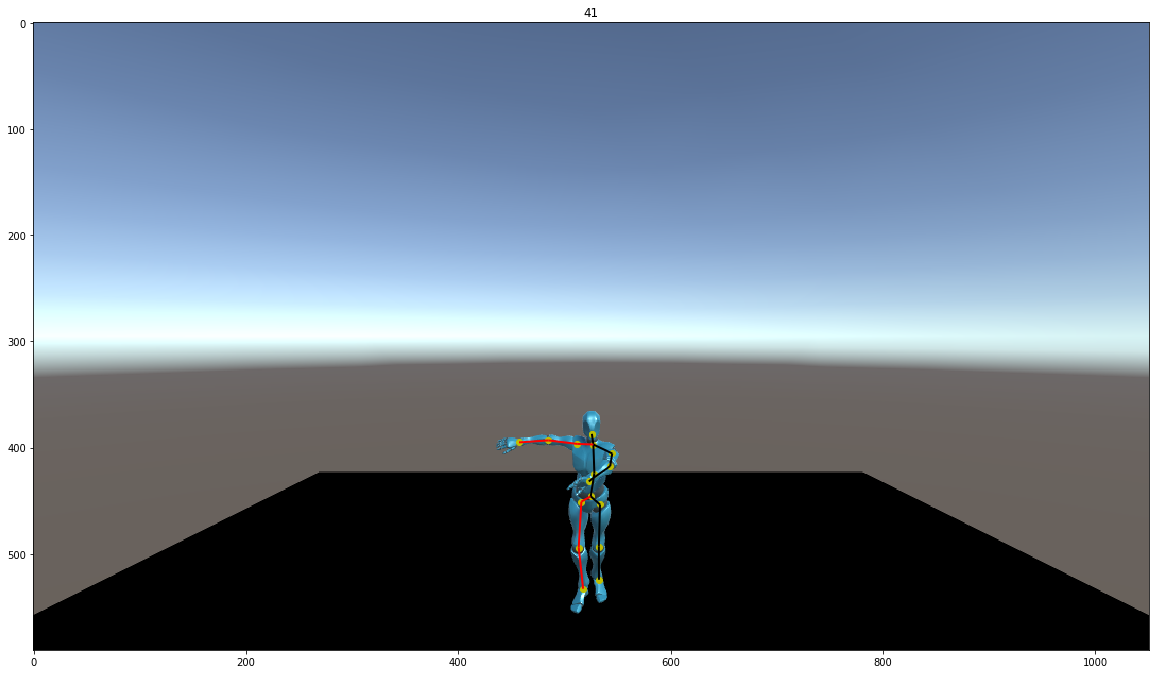

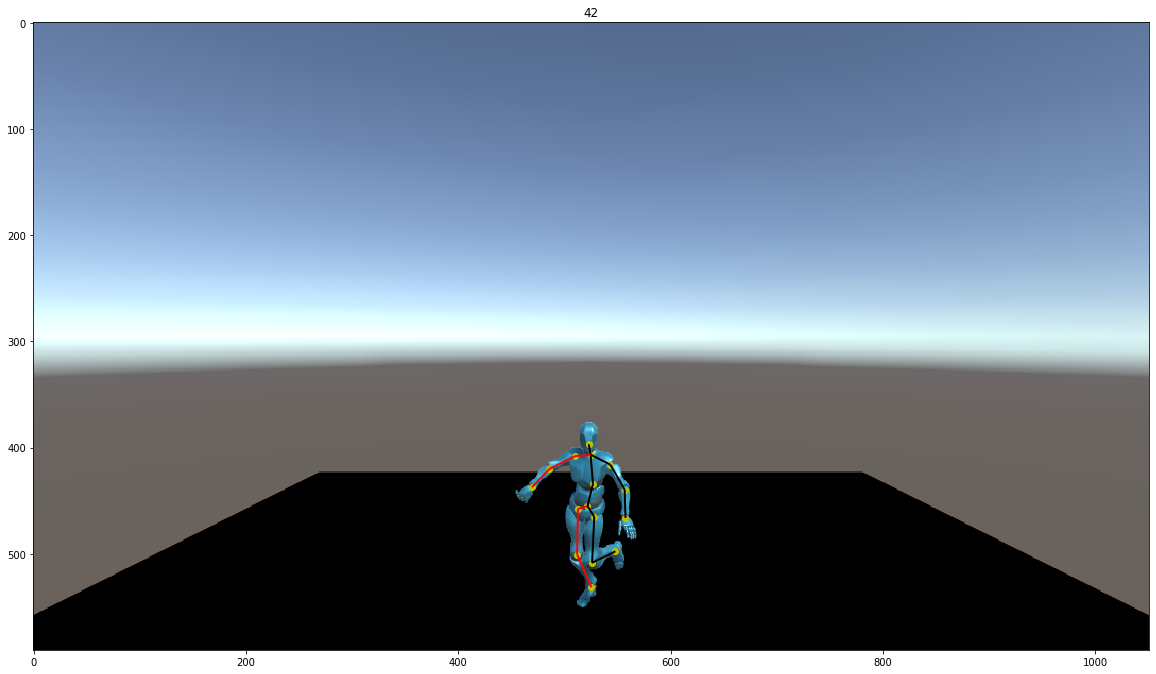

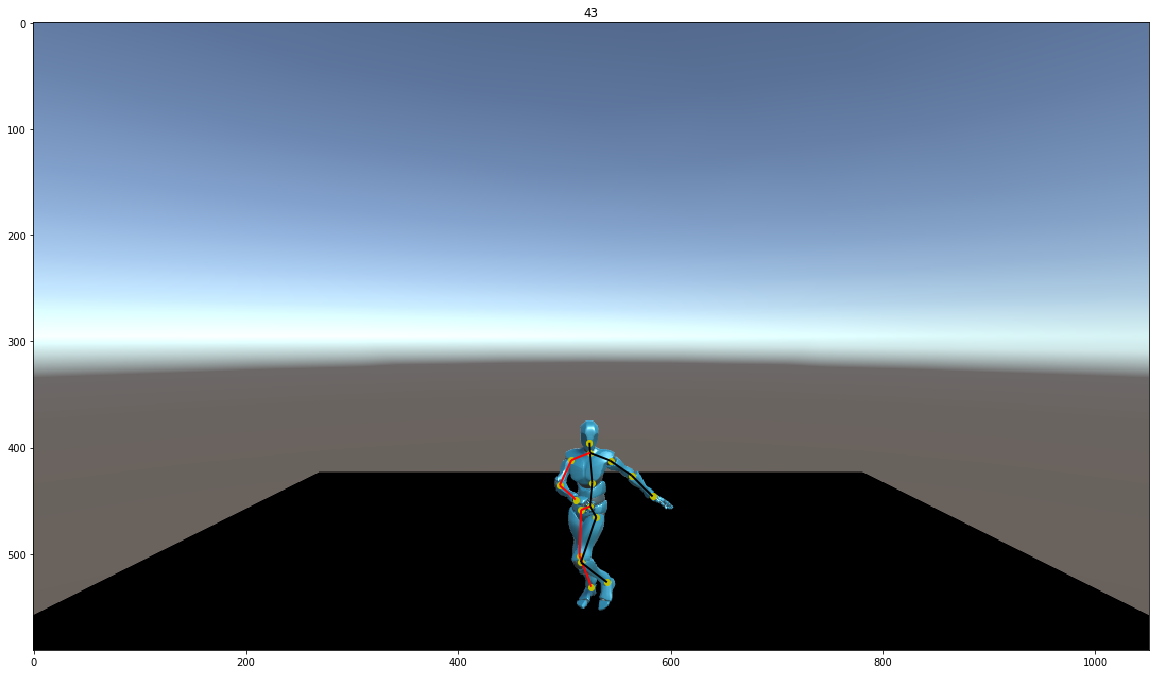

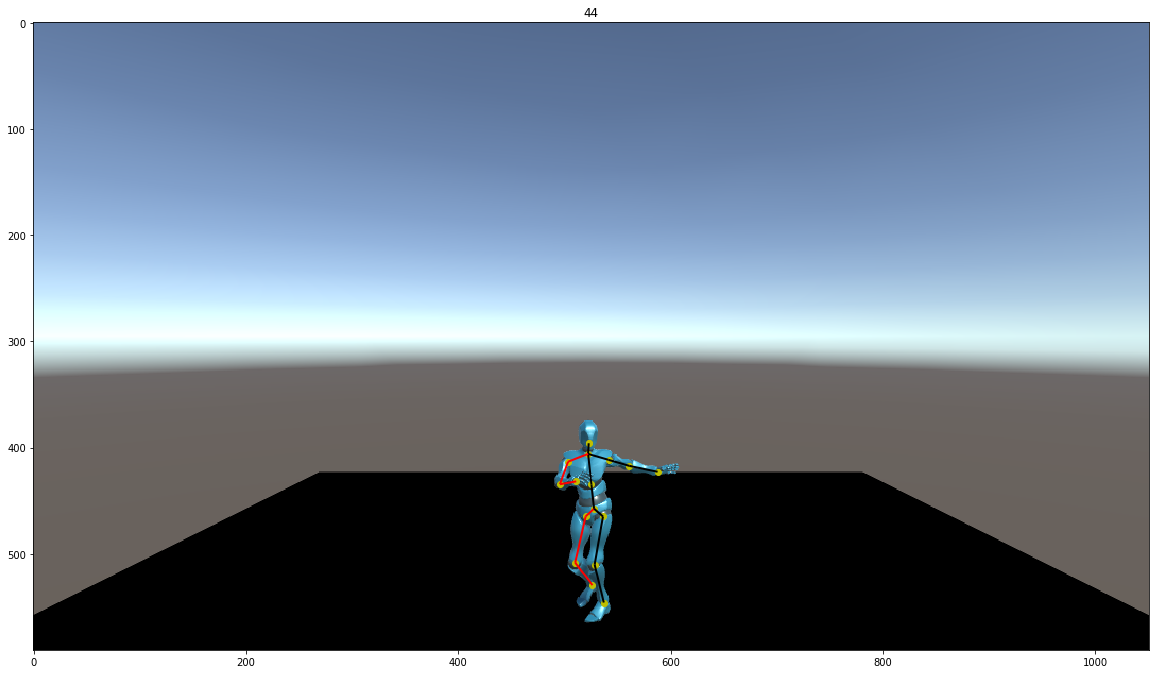

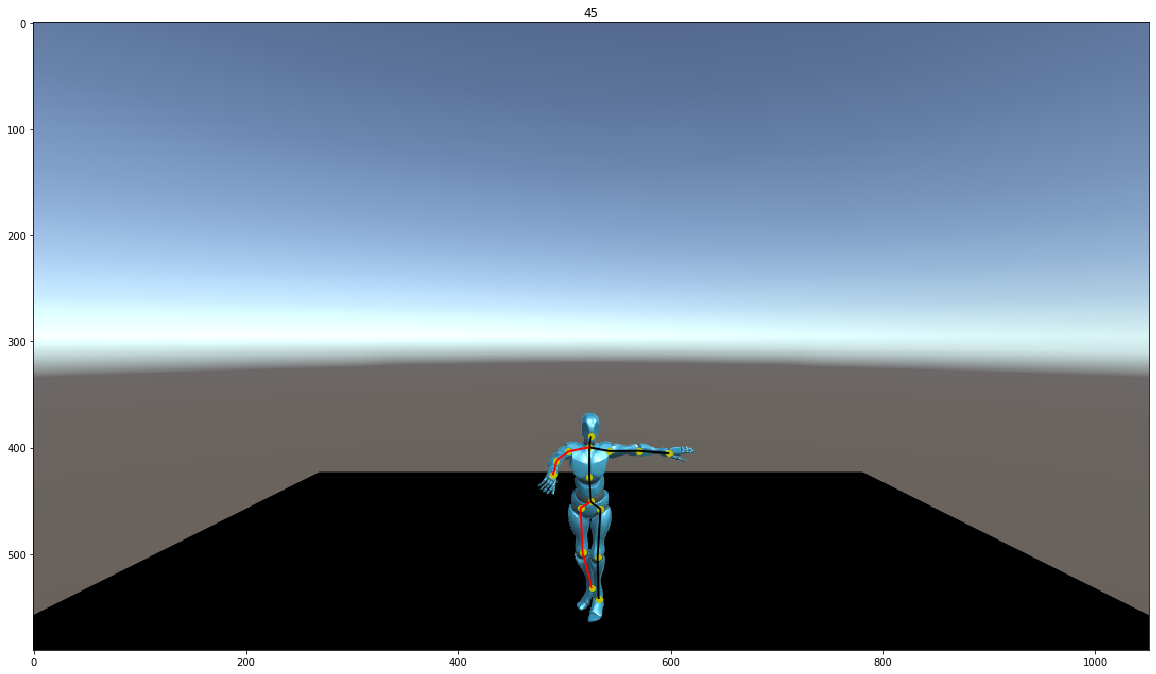

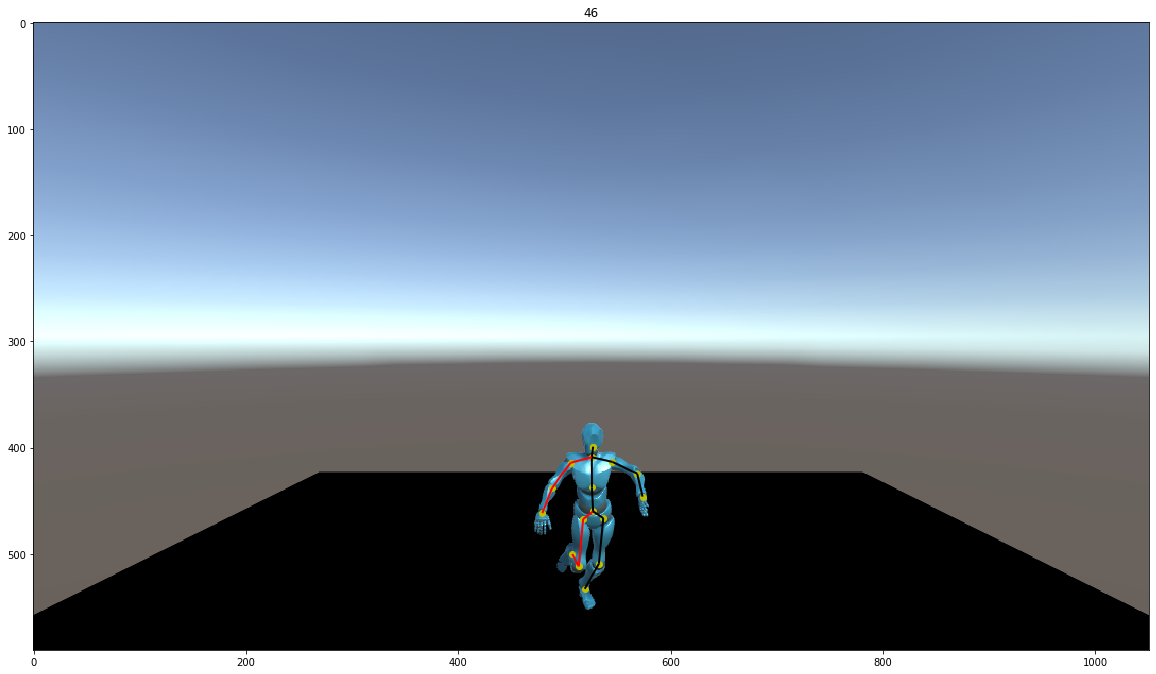

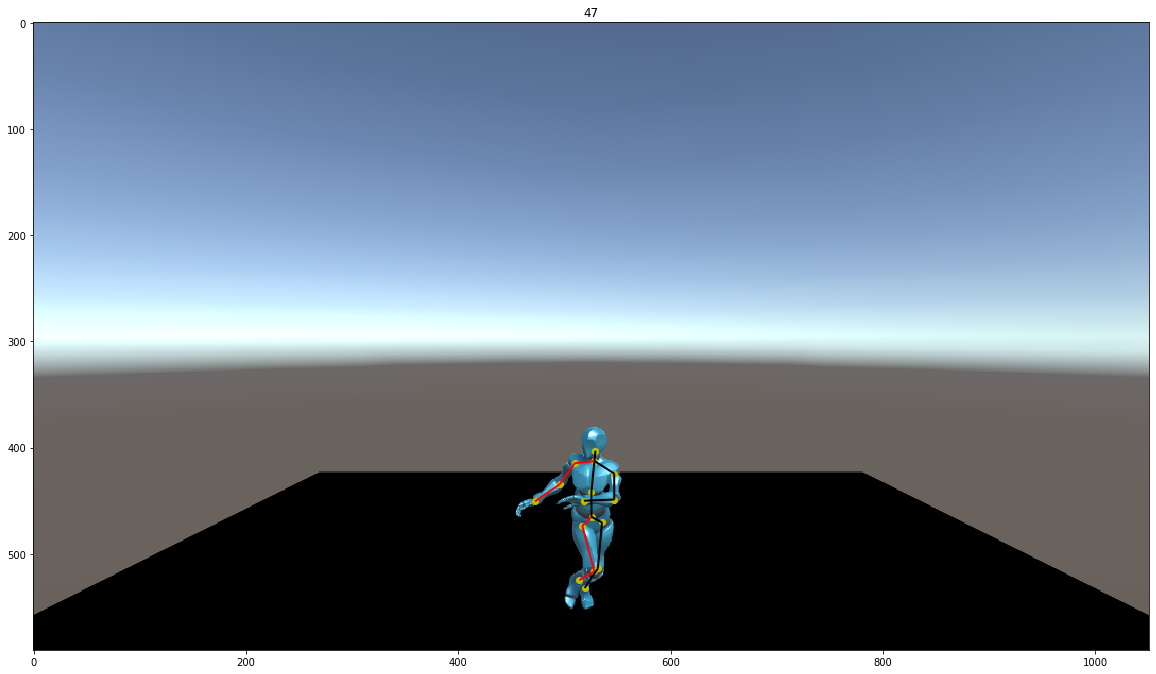

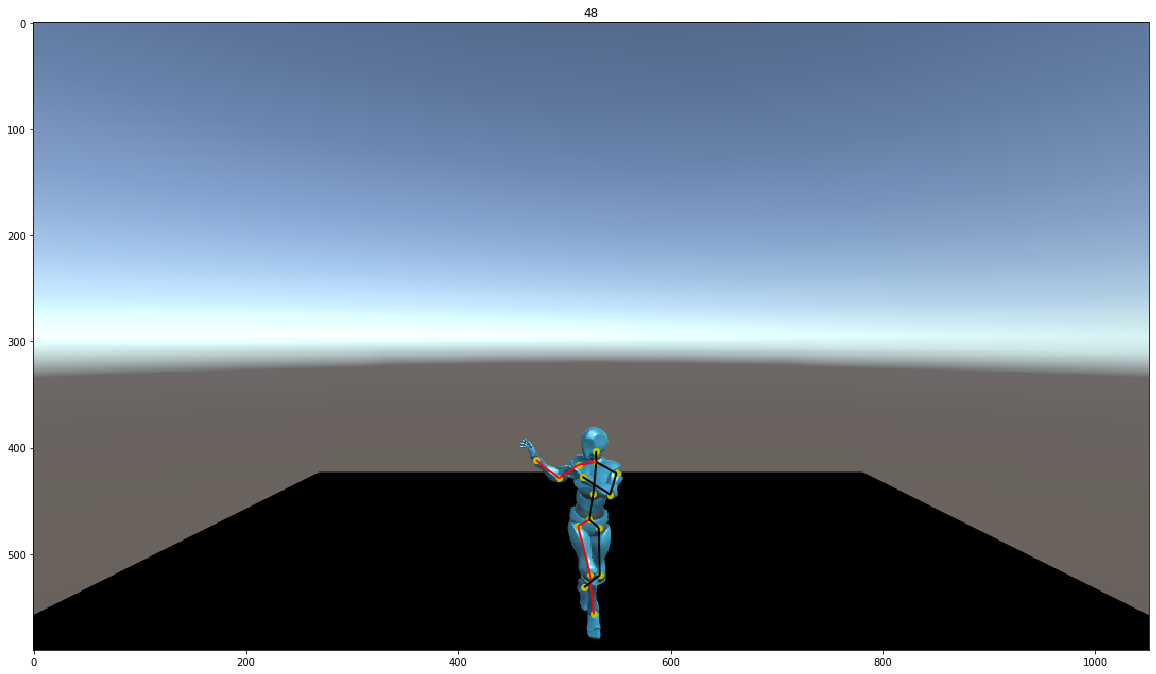

In [5]:
for m in range(49):
    fig = plt.figure(figsize=(20,20))
    ax_2d = fig.add_subplot(1,1,1, aspect='equal')
    ax_2d = display_2D_skeleton_beta(ax_2d, pts_2d[m], skeleton, imgs[m])
    ax_2d.set_title(m)
    plt.show()

In [6]:
frames, layout = generate_frames_layout(pts_3d, skeleton, human36m_kpts_name)
fig = dict(data=get_line_3d_segs(pts_3d, 0, skeleton, human36m_kpts_name), layout=layout, frames=frames)
plotly.offline.iplot(fig)

camera parameters

In [46]:
cameraInfo = data["CameraInfo"]
camera2world = np.array([ list(map(lambda x : float(x), r.split("\t"))) for r in [r for r in cameraInfo["camera2world"].split("\n")][:-1]])
world2camera = np.array([ list(map(lambda x : float(x), r.split("\t"))) for r in [r for r in cameraInfo["world2camera"].split("\n")][:-1]])
projMat = np.array([ list(map(lambda x : float(x), r.split("\t"))) for r in [r for r in cameraInfo["projection_Matrix"].split("\n")][:-1]])

In [88]:
world2camera

array([[-1. ,  0. ,  0. ,  0. ],
       [ 0. ,  1. ,  0. , -2.5],
       [ 0. ,  0. ,  1. , -5. ],
       [ 0. ,  0. ,  0. ,  1. ]])

In [47]:
projMat

array([[ 0.97397,  0.     ,  0.     ,  0.     ],
       [ 0.     ,  1.73205,  0.     ,  0.     ],
       [ 0.     ,  0.     , -1.00002, -0.02   ],
       [ 0.     ,  0.     , -1.     ,  0.     ]])

In [48]:
cameraIntrinsics = np.load("./wild_data/2019.05.30_14.03/camera_0_intrinsics.npy")

In [87]:
cameraIntrinsics

267803.7498680213

In [61]:
sample_3d = pts_3d[-1]
sample_2d = pts_2d[-1]

In [66]:
sample_2d[0][0], sample_2d[0][1]

(523.266536295414, 467.57557019591303)

In [82]:
sample_3d_homo = np.ones((4,1))
sample_3d_homo[:3] = sample_3d[0].reshape((-1,1))

In [85]:
np.matmul(world2camera, sample_3d_homo)

array([[-0.0208743 ],
       [-1.60826749],
       [-4.78362459],
       [ 1.        ]])

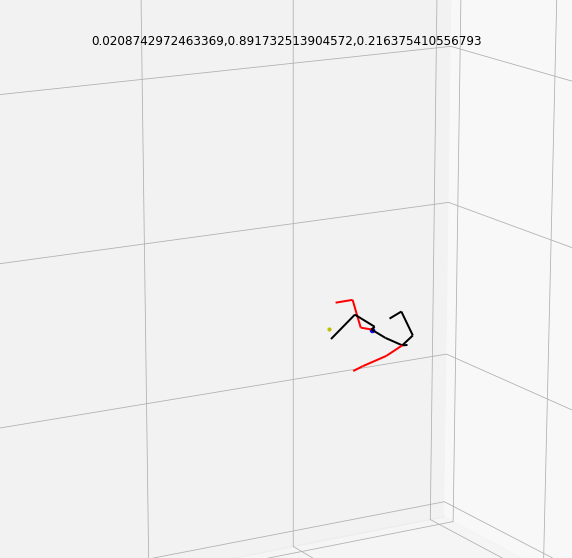

In [75]:
fig = plt.figure(figsize=(10,10))
ax_3d = fig.add_subplot(1,1,1,projection='3d')
ax_3d = display_3D_skeleton_beta(ax_3d, sample_3d, skeleton)
ax_3d.scatter(sample_3d[0][0], sample_3d[0][1], sample_3d[0][2],c = "b")
ax_3d.dist = 3
ax_3d.set_title(",".join([str(i) for i in sample_3d[0]]))
plt.show()

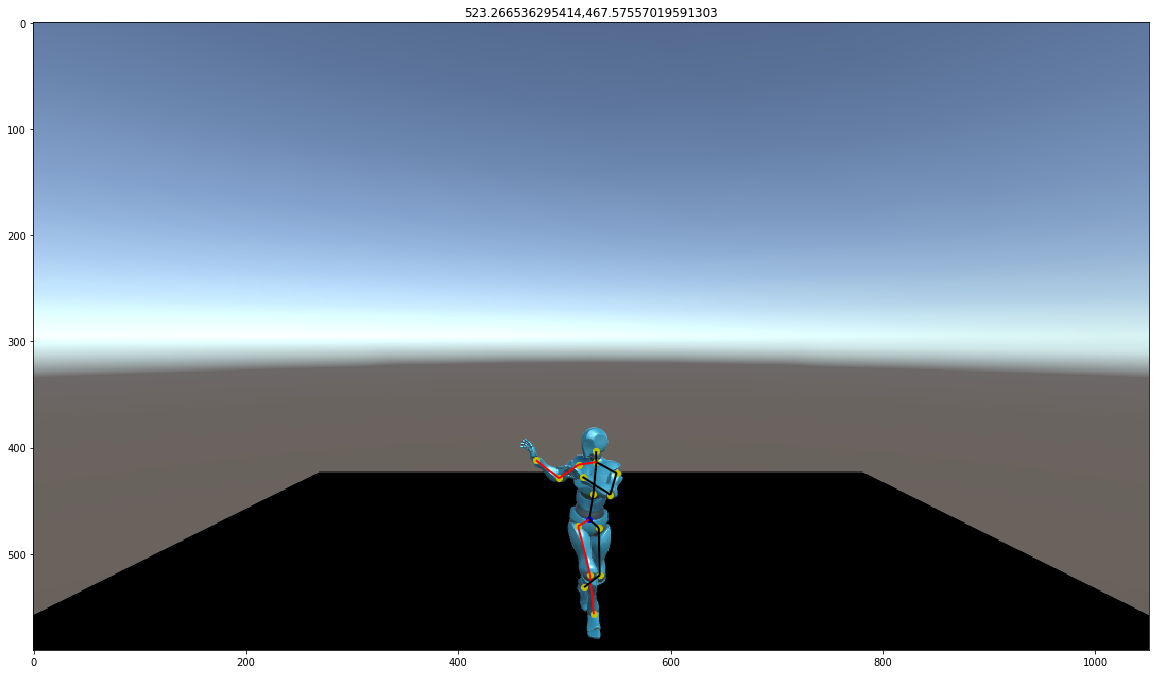

In [76]:
fig = plt.figure(figsize=(20,20))
ax_2d = fig.add_subplot(1,1,1, aspect='equal')
ax_2d = display_2D_skeleton_beta(ax_2d, sample_2d, skeleton, imgs[-1])
ax_2d.scatter(sample_2d[0][0], sample_2d[0][1], c = "b")
ax_2d.set_title(",".join([str(i) for i in sample_2d[0]]))
plt.show()